<a href="https://colab.research.google.com/github/OBulun/AN2DL_CH_2/blob/Francesco/v6_DenseNet121_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [1]:
from google.colab import drive
drive.mount("/gdrive")
# Define current_dir correctly for Python (no backslashes for spaces)
current_dir = "/gdrive/My Drive/AN2DL Challenge 2"
# Use the correctly formatted path for the %cd magic command, quoting it for safety
%cd "$current_dir"

Mounted at /gdrive
/gdrive/My Drive/AN2DL Challenge 2


## 1. Import Libraries

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
import gc
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
!pip install torchview
from torchview import draw_graph
from torch.utils.data import Dataset
from torchvision.transforms import RandAugment
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## **2. Data Loading**

In [3]:
# Assume datasets are in the current working directory, which is now correctly formatted
datasets_path = current_dir

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

output_path = os.path.join(datasets_path, "train_masked")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path             # Folder containing img_xxxx and mask_xxxx
OUTPUT_FOLDER = output_path                 # Where the resized and masked images will be saved

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks
Target_dimension = 224

# CSV_PATH = str(train_labels_path)
# SOURCE_FOLDER = str(train_data_path)
# OUTPUT_FOLDER = str(output_path)
# if not Path(SOURCE_FOLDER).exists():
#     candidate_datasets = [
#         datasets_path,
#         base_path.parent / "an2dl2526c2",
#         Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
#     ]
#     for candidate in candidate_datasets:
#         if candidate.exists():
#             datasets_path = candidate
#             train_data_path = datasets_path / "train_data"
#             train_labels_path = datasets_path / "train_labels.csv"
#             test_data_path = datasets_path / "test_data"
#             output_path = datasets_path / "train_masked"

#             CSV_PATH = str(train_labels_path)
#             SOURCE_FOLDER = str(train_data_path)
#             OUTPUT_FOLDER = str(output_path)

#             print(f"Resolved dataset path: {datasets_path}")
#             break
#     else:
#         raise FileNotFoundError(
#             "Dataset folder not found in any of the candidate locations:\n"
#             + "\n".join(str(p) for p in candidate_datasets)
#         )

Dataset path: /gdrive/My Drive/AN2DL Challenge 2
Train data path: /gdrive/My Drive/AN2DL Challenge 2/train_data
Train labels path: /gdrive/My Drive/AN2DL Challenge 2/train_labels.csv
Test data path: /gdrive/My Drive/AN2DL Challenge 2/test_data
Output path: /gdrive/My Drive/AN2DL Challenge 2/train_masked


In [4]:
def apply_mask(image_path, mask_path, output_path, target_size=TARGET_SIZE):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)                                # REMOVED SINCE WE DON'T WANT DISTORSION IN THE IMAGES AND MASKS.
        # Resize mask using nearest neighbor to preserve sharp edges      # BETTER TO SCALE THEM ACCORDING TO THEIR ACTUAL DIMENSIONS
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    # added multiply opencv method for computing image and mask element-wise multiplication
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [5]:
def process_batch(input_dir, output_dir, target_size=TARGET_SIZE):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir()
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]

    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0

    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name

        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")

        if mask_path.exists():
            output_path = output_dir / file_path.name

            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [6]:
def load_images_from_folder(folder, target_size=TARGET_SIZE):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []

    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        # Resize the image to the target size to ensure consistency
        img = cv2.resize(img, target_size)

        images.append(img)

    return np.array(images)

In [7]:
source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)

if not source_dir.exists():
	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
	source_dir.mkdir(parents=True, exist_ok=True)

output_dir.mkdir(parents=True, exist_ok=True)

process_batch(str(source_dir), str(output_dir), target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = str(output_dir)


Scanning for images in: /gdrive/My Drive/AN2DL Challenge 2/train_data...


Processing Images: 100%|██████████| 691/691 [00:49<00:00, 13.95img/s] 

Batch processing complete. Processed 66 new images.


In [8]:
train_images = load_images_from_folder(MASKED_IMAGE_PATH)
print(f"Loaded {len(train_images)}  images")


Loading images from train_masked: 100%|██████████| 691/691 [00:22<00:00, 30.70it/s]


Loaded 691  images


## **3. Exploration and Data Analysis**

In [9]:
# Add this cell before your visualization
print(f"MASKED_IMAGE_PATH: {MASKED_IMAGE_PATH}")
print(f"Path exists: {Path(MASKED_IMAGE_PATH).exists()}")
print(f"Number of files: {len(os.listdir(MASKED_IMAGE_PATH)) if Path(MASKED_IMAGE_PATH).exists() else 0}")
print(f"train_images shape: {train_images.shape}")

MASKED_IMAGE_PATH: /gdrive/My Drive/AN2DL Challenge 2/train_masked
Path exists: True
Number of files: 691
train_images shape: (691, 224, 224, 3)


In [10]:
# Labels distributions in the dataset
df_labels = pd.read_csv(train_labels_path)
df_labels.head()

label_counts = df_labels['label'].value_counts()
label_percentages = df_labels['label'].value_counts(normalize=True) * 100

print("Number of samples per class:")
print(label_counts)

print("\nClass distribution in percentage:")
print(label_percentages.round(2)/100)


Number of samples per class:
label
Luminal B          220
Luminal A          205
HER2(+)            189
Triple negative     77
Name: count, dtype: int64

Class distribution in percentage:
label
Luminal B          0.3184
Luminal A          0.2967
HER2(+)            0.2735
Triple negative    0.1114
Name: proportion, dtype: float64


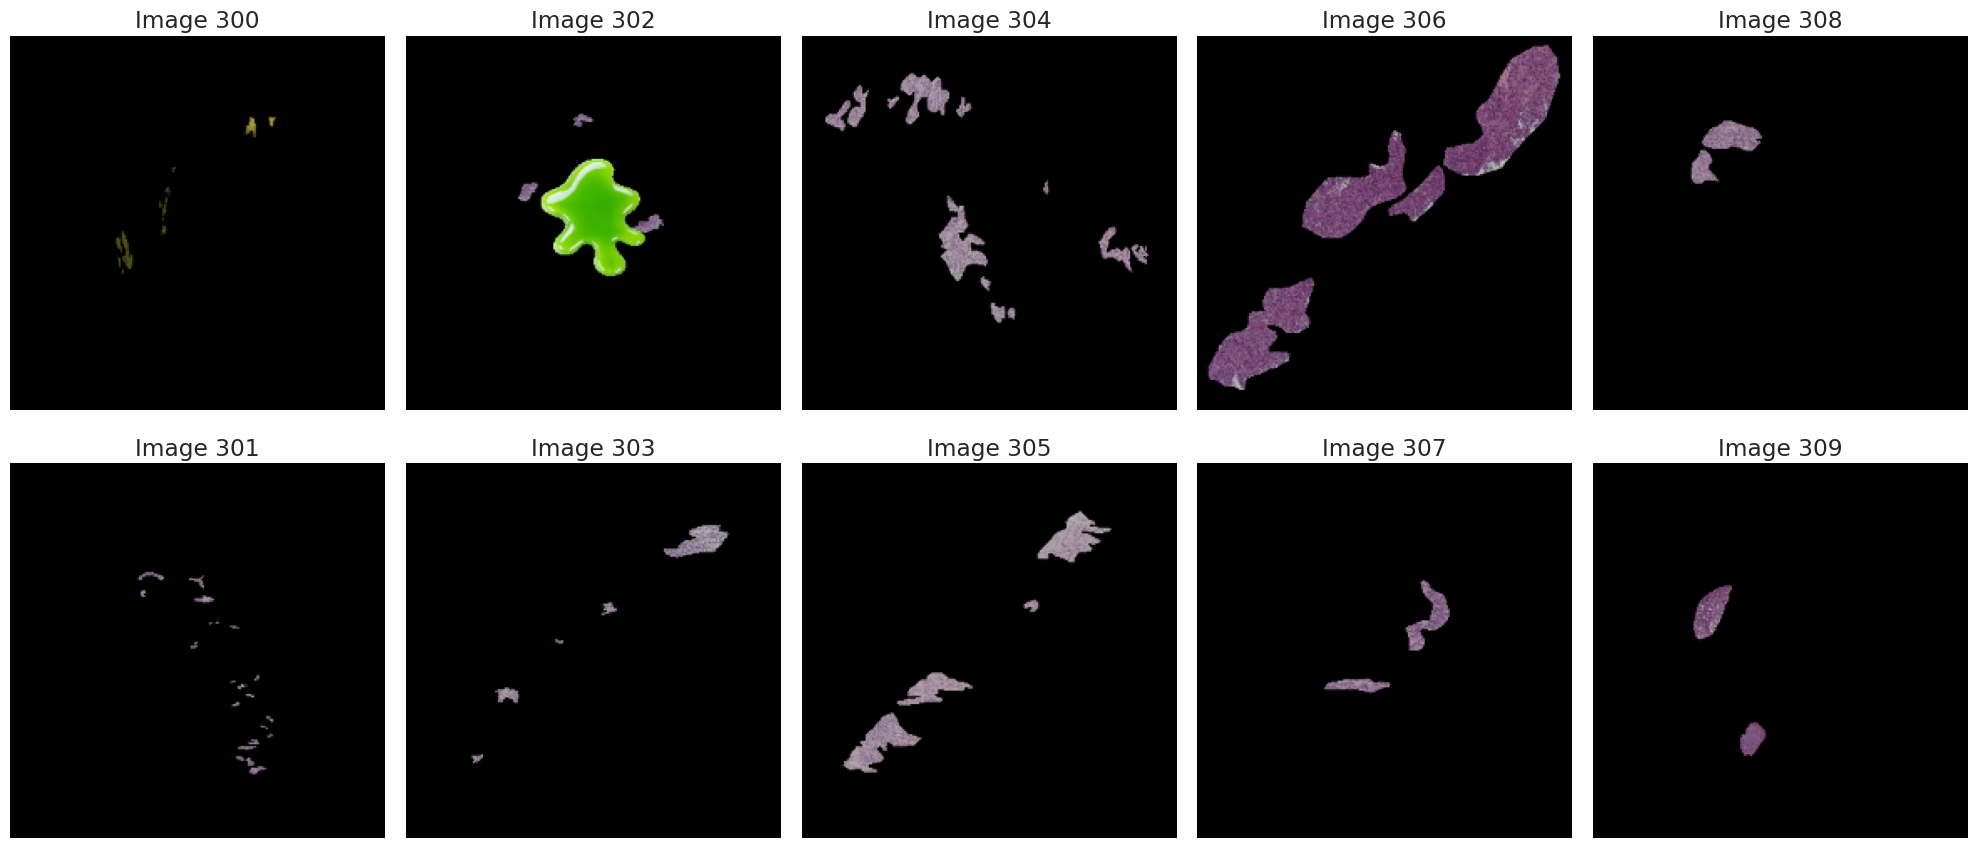

In [11]:
# Number of images to display
num_img = 10
start_img= 300
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    # Add the image index into the imageshow
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


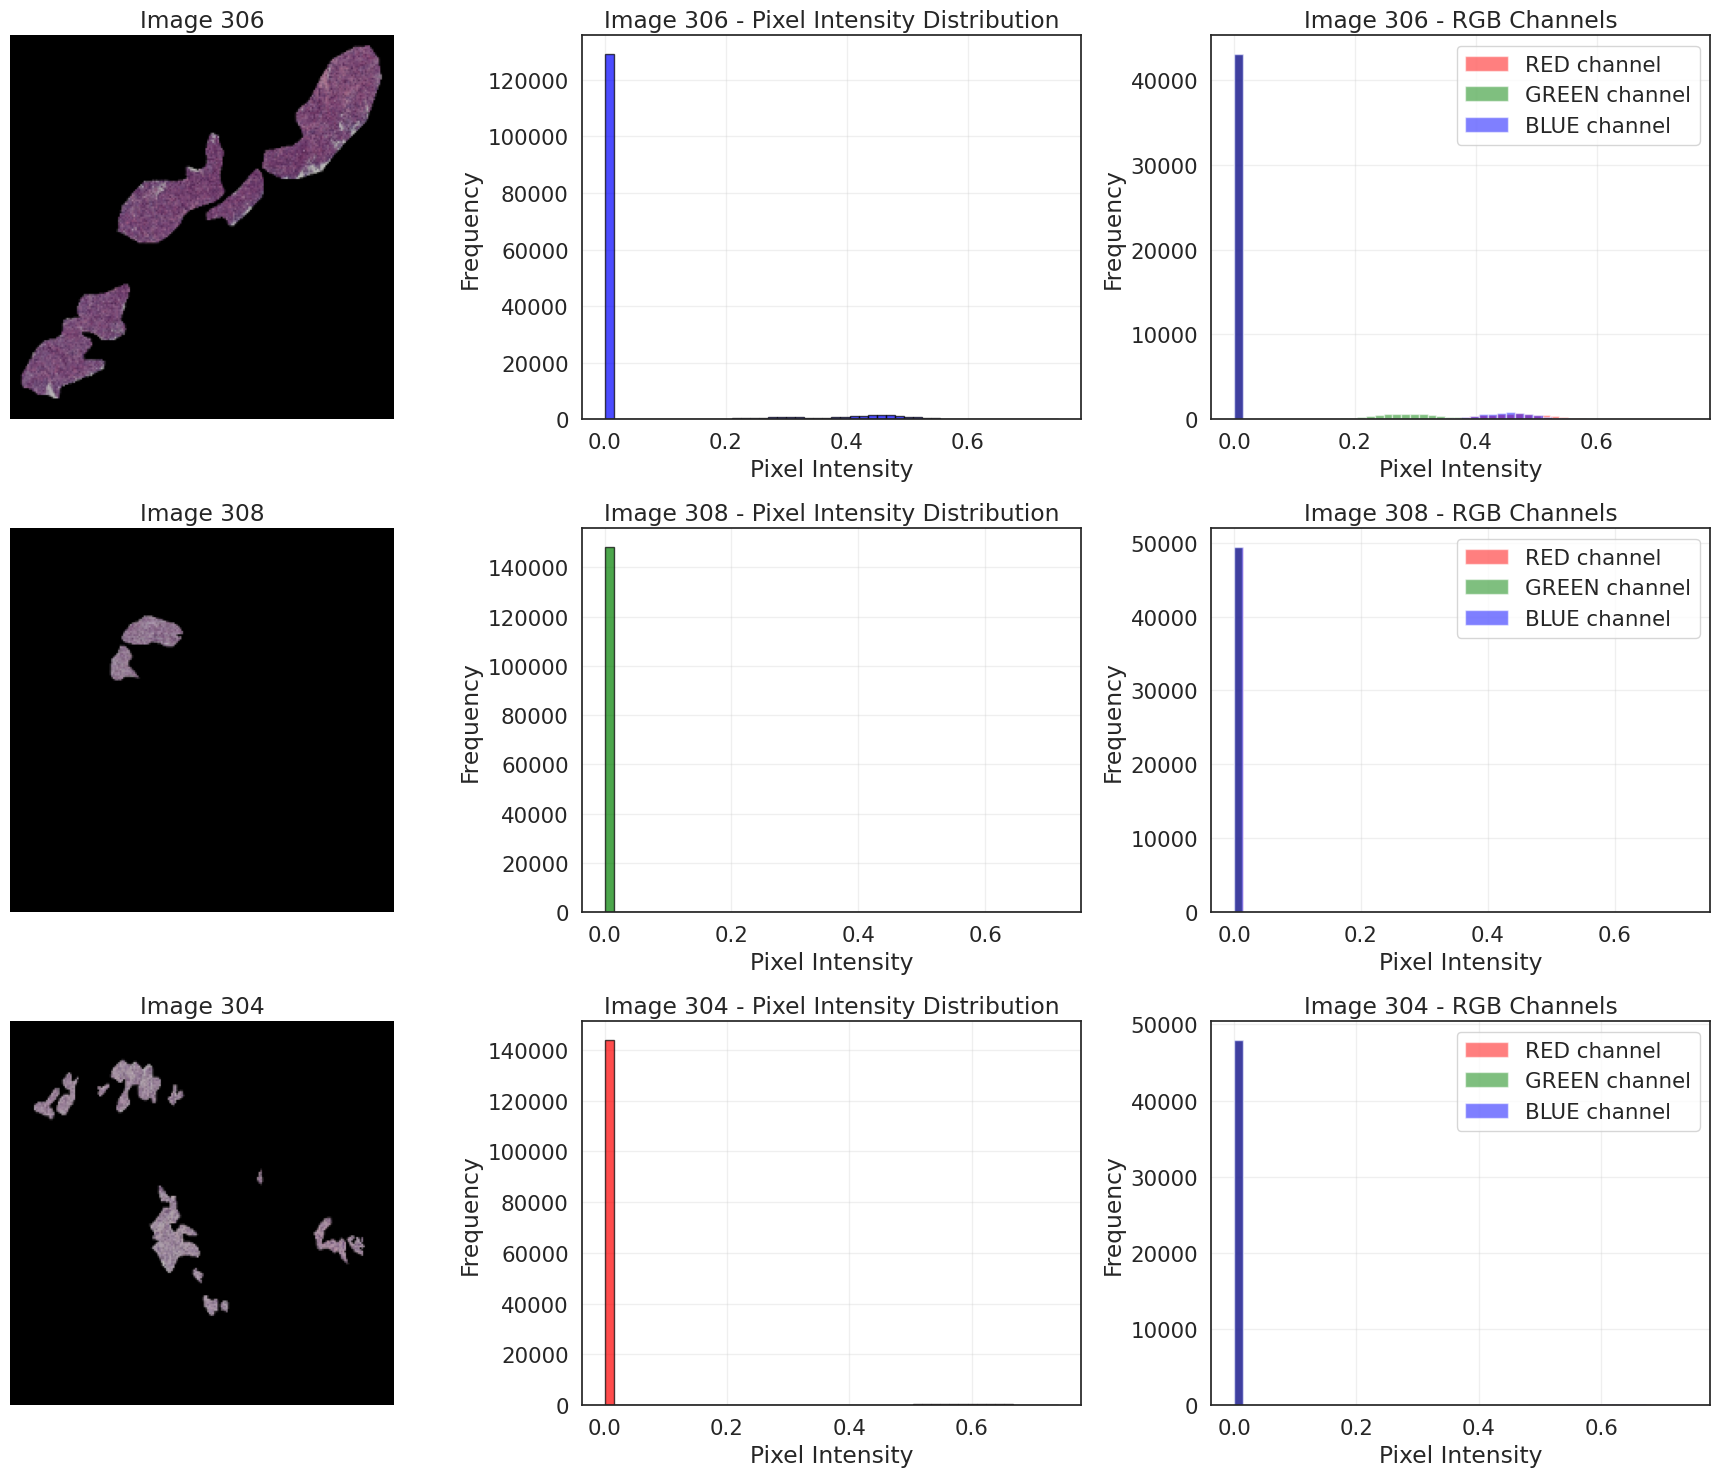

Image 306 Statistics:
  Mean intensity: 0.0554
  Std deviation: 0.1438
  Min: 0.0000, Max: 0.7500

Image 308 Statistics:
  Mean intensity: 0.0069
  Std deviation: 0.0595
  Min: 0.0000, Max: 0.7150

Image 304 Statistics:
  Mean intensity: 0.0213
  Std deviation: 0.1068
  Min: 0.0000, Max: 0.7417

Green Channel Statistics:
Image 304 - Green channel mean: 0.0195, std: 0.0974
Image 308 - Green channel mean: 0.0060, std: 0.0521

Red Channel Statistics:
Image 304 - Red channel mean: 0.0223, std: 0.1117
Image 308 - Red channel mean: 0.0073, std: 0.0628

Blue Channel Statistics:
Image 304 - Blue channel mean: 0.0222, std: 0.1107
Image 308 - Blue channel mean: 0.0073, std: 0.0630


In [12]:
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]
img_304 = train_images[304]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Display Image 306
axes[0, 0].imshow(np.clip(img_306, 0, 1))
axes[0, 0].set_title("Image 306")
axes[0, 0].axis('off')

# Display Image 308
axes[1, 0].imshow(np.clip(img_308, 0, 1))
axes[1, 0].set_title("Image 308")
axes[1, 0].axis('off')

# Display Image 304
axes[2, 0].imshow(np.clip(img_304, 0, 1))
axes[2, 0].set_title("Image 304")
axes[2, 0].axis('off')

# Pixel intensity histogram for Image 306 (all channels combined)
axes[0, 1].hist(img_306.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title("Image 306 - Pixel Intensity Distribution")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Pixel intensity histogram for Image 308 (all channels combined)
axes[1, 1].hist(img_308.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title("Image 308 - Pixel Intensity Distribution")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True, alpha=0.3)

# Pixel intensity histograms for Image 304
axes[2, 1].hist(img_304.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
axes[2, 1].set_title("Image 304 - Pixel Intensity Distribution")
axes[2, 1].set_xlabel("Pixel Intensity")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True, alpha=0.3)

# RGB channel histograms for Image 306
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[0, 2].hist(img_306[:, :, channel].flatten(), bins=50,
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[0, 2].set_title("Image 306 - RGB Channels")
axes[0, 2].set_xlabel("Pixel Intensity")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 308
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[1, 2].hist(img_308[:, :, channel].flatten(), bins=50,
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[1, 2].set_title("Image 308 - RGB Channels")
axes[1, 2].set_xlabel("Pixel Intensity")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 304
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[2, 2].hist(img_304[:, :, channel].flatten(), bins=50,
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[2, 2].set_title("Image 304 - RGB Channels")
axes[2, 2].set_xlabel("Pixel Intensity")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Image 306 Statistics:")
print(f"  Mean intensity: {img_306.mean():.4f}")
print(f"  Std deviation: {img_306.std():.4f}")
print(f"  Min: {img_306.min():.4f}, Max: {img_306.max():.4f}")

print("\nImage 308 Statistics:")
print(f"  Mean intensity: {img_308.mean():.4f}")
print(f"  Std deviation: {img_308.std():.4f}")
print(f"  Min: {img_308.min():.4f}, Max: {img_308.max():.4f}")

print("\nImage 304 Statistics:")
print(f"  Mean intensity: {img_304.mean():.4f}")
print(f"  Std deviation: {img_304.std():.4f}")
print(f"  Min: {img_304.min():.4f}, Max: {img_304.max():.4f}")

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Green channel mean: {img_304[:, :, 1].mean():.4f}, std: {img_304[:, :, 1].std():.4f}")
print(f"Image 308 - Green channel mean: {img_308[:, :, 1].mean():.4f}, std: {img_308[:, :, 1].std():.4f}")

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Red channel mean: {img_304[:, :, 0].mean():.4f}, std: {img_304[:, :, 0].std():.4f}")
print(f"Image 308 - Red channel mean: {img_308[:, :, 0].mean():.4f}, std: {img_308[:, :, 0].std():.4f}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Blue channel mean: {img_304[:, :, 2].mean():.4f}, std: {img_304[:, :, 2].std():.4f}")
print(f"Image 308 - Blue channel mean: {img_308[:, :, 2].mean():.4f}, std: {img_308[:, :, 2].std():.4f}")


Analyzing green channel frequency for all images...


Analyzing images: 100%|██████████| 691/691 [00:00<00:00, 1976.60it/s]



Top 20 images with highest green intensity frequency (>0.5):
Index | High Green % | Dominant Green %
--------------------------------------------------
  124 |       11.42% |            0.01%
  231 |       11.32% |            5.17%
  511 |        9.73% |            0.06%
  689 |        6.55% |            0.01%
  589 |        6.54% |            4.94%
  590 |        6.40% |            5.02%
  133 |        6.35% |            5.17%
  373 |        6.20% |            0.00%
  212 |        6.05% |            5.18%
  549 |        5.97% |            4.95%
  645 |        5.77% |            4.95%
  287 |        5.69% |            5.20%
  540 |        5.65% |            4.94%
  504 |        5.64% |            5.20%
  547 |        5.62% |            4.95%
  264 |        5.50% |            5.16%
  533 |        5.48% |            0.02%
  574 |        5.47% |            4.95%
  635 |        5.41% |            4.97%
  234 |        5.41% |            5.17%


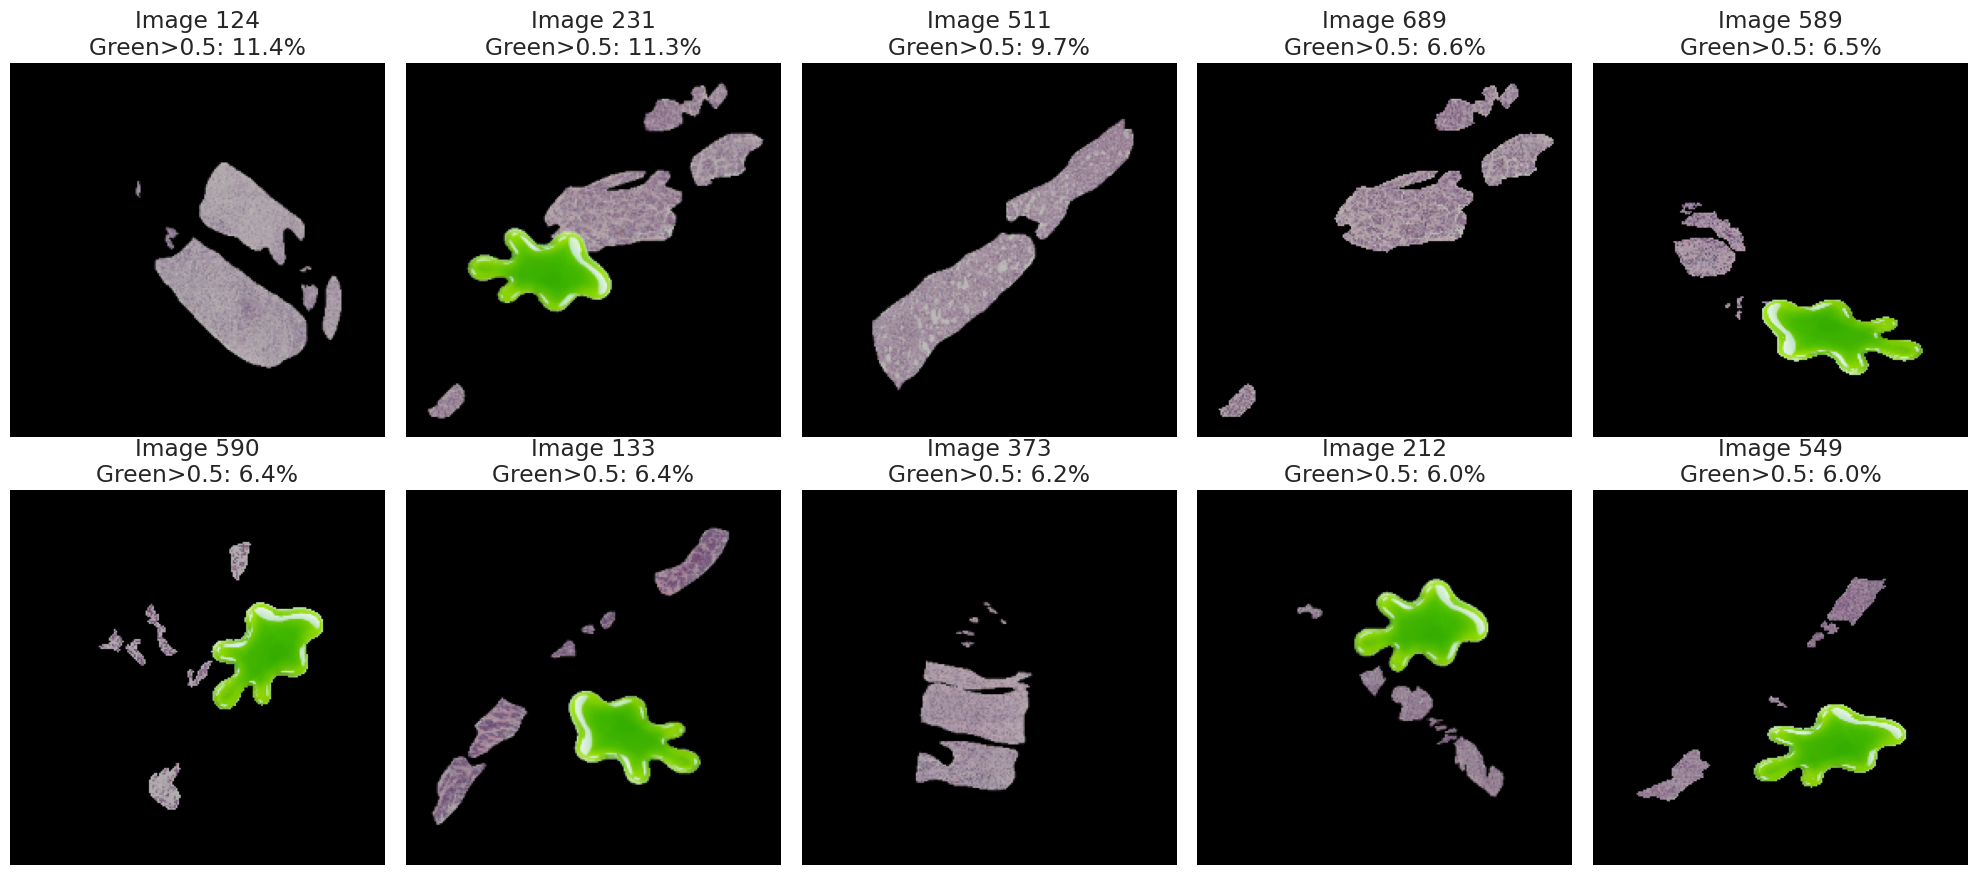


Selected 0 images with >20.0% high green intensity
Indices: []

Stored 0 images in 'selected_green_images' array
Shape: (0, 224, 224, 3)


In [13]:
# Identify images with high green channel intensity frequency
# Based on the histogram analysis, select images where green channel dominates

def analyze_green_frequency(image):
    """
    Analyze green channel frequency distribution.
    Returns the percentage of pixels where green channel has high intensity (>0.5)
    and where green is the dominant channel.
    """
    green_channel = image[:, :, 1]

    # Count pixels with high green intensity (>0.5)
    high_green_pixels = np.sum(green_channel > 0.5)

    # Count pixels where green is dominant (G > R and G > B)
    green_dominant = np.sum(
        (image[:, :, 1] > image[:, :, 0]) &
        (image[:, :, 1] > image[:, :, 2])
    )

    total_pixels = image.shape[0] * image.shape[1]
    high_green_percentage = (high_green_pixels / total_pixels) * 100
    dominant_green_percentage = (green_dominant / total_pixels) * 100

    return high_green_percentage, dominant_green_percentage

# Analyze all images
print("Analyzing green channel frequency for all images...")
green_analysis = []
for idx, img in enumerate(tqdm(train_images, desc="Analyzing images")):
    high_green_pct, dominant_green_pct = analyze_green_frequency(img)
    green_analysis.append({
        'index': idx,
        'high_green_pct': high_green_pct,
        'dominant_green_pct': dominant_green_pct
    })

# Convert to DataFrame for easy sorting
df_green = pd.DataFrame(green_analysis)

# Sort by high green intensity percentage
df_sorted_high = df_green.sort_values('high_green_pct', ascending=False)

# Display top 20 images with highest green intensity frequency
print("\nTop 20 images with highest green intensity frequency (>0.5):")
print("Index | High Green % | Dominant Green %")
print("-" * 50)
for _, row in df_sorted_high.head(20).iterrows():
    print(f"{int(row['index']):5d} | {row['high_green_pct']:11.2f}% | {row['dominant_green_pct']:15.2f}%")

# Visualize top 10 images with highest green frequency
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()
for i, (_, row) in enumerate(df_sorted_high.head(10).iterrows()):
    idx = int(row['index'])
    axes[i].imshow(np.clip(train_images[idx], 0, 1))
    axes[i].set_title(f"Image {idx}\nGreen>0.5: {row['high_green_pct']:.1f}%")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Select images based on threshold
green_threshold = 20.0  # Select images with >20% high green intensity
selected_green_indices = df_green[df_green['high_green_pct'] > green_threshold]['index'].values.astype(int).tolist()

print(f"\nSelected {len(selected_green_indices)} images with >{green_threshold}% high green intensity")
print(f"Indices: {selected_green_indices[:50]}")  # Show first 50

# Store the selected images
selected_green_images = train_images[selected_green_indices]
print(f"\nStored {len(selected_green_images)} images in 'selected_green_images' array")
print(f"Shape: {selected_green_images.shape}")

### Green Area Removal Filter

In [14]:
def filter_bright_green_areas(image, lg_H=60-50, lg_S=10, lg_V=50, ug_H=60+50, ug_S=255, ug_V=255, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.

    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)

    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

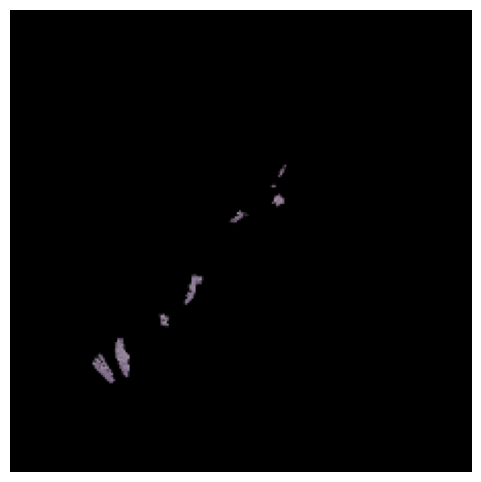

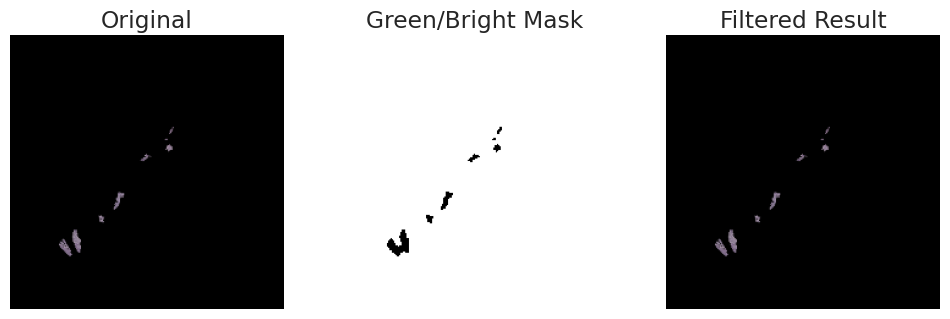

In [15]:
# Display the pixels values of an image with green areas
image_index = 102
image = train_images[image_index]
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

result_bgr, clean_mask = filter_bright_green_areas(image)

# --- Display Results ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')

# The Mask (Visualizing what we are removing)
plt.subplot(1, 3, 2)
plt.title("Green/Bright Mask")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')

# Result
result_rgb = result_bgr[..., ::-1]
plt.subplot(1, 3, 3)
plt.title("Filtered Result")
plt.imshow(np.clip(result_rgb / 255.0, 0, 1))
plt.axis('off')

plt.show()

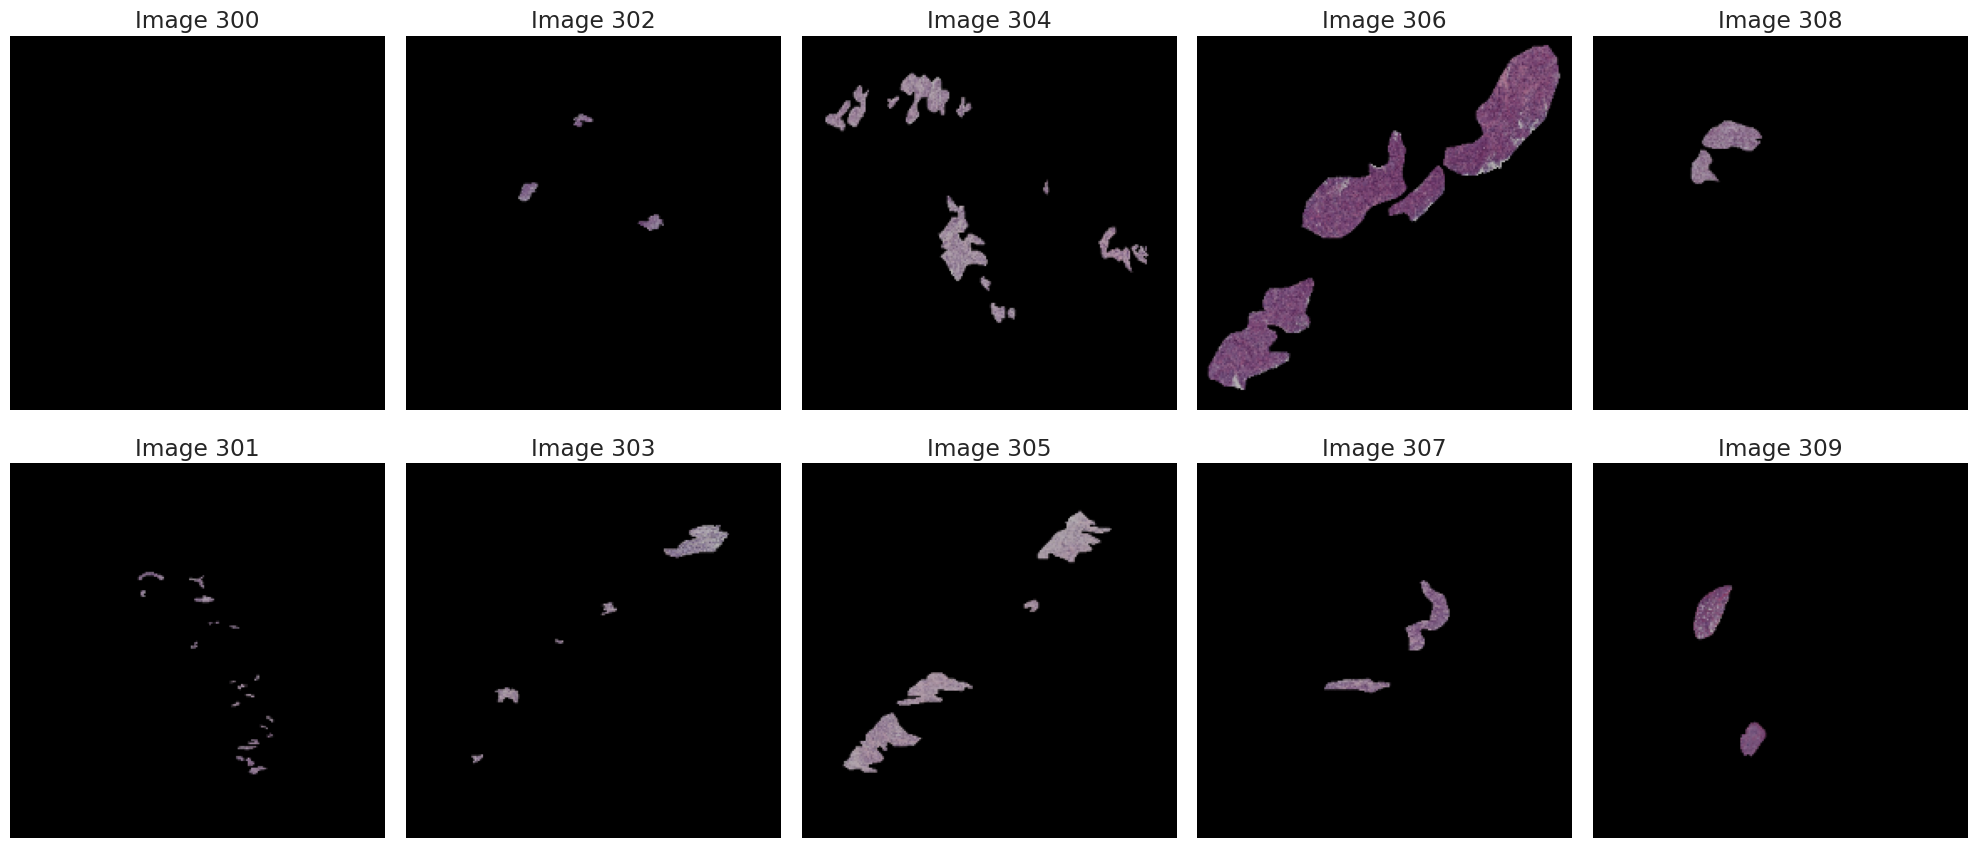

In [16]:
# Convert from BGR to RGB for displaying
result_rgb = result_bgr[..., ::-1]


# Apply the HSV filter for all the images into the training set and normalize them
for image in train_images:
    filtered_bgr, _ = filter_bright_green_areas(image)
    # Convert back to RGB and normalize to [0, 1]
    filtered_rgb = filtered_bgr[..., ::-1] / 255.0
    # Update the image in place
    image[:] = filtered_rgb

# Number of images to display
num_img = 10
start_img= 300
# Create again subplots for displaying the filtered items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


In [17]:
# Print RBG channel for 308 and 304 images
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]
img_304 = train_images[304]

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 1].mean()}, Std: {img_304[..., 1].std()}")
print(f"Image 308 - Mean: {img_308[..., 1].mean()}, Std: {img_308[..., 1].std()}")
print(f"Image 306 - Mean: {img_306[..., 1].mean()}, Std: {img_306[..., 1].std()}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 2].mean()}, Std: {img_304[..., 2].std()}")
print(f"Image 308 - Mean: {img_308[..., 2].mean()}, Std: {img_308[..., 2].std()}")
print(f"Image 306 - Mean: {img_306[..., 2].mean()}, Std: {img_306[..., 2].std()}")

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 0].mean()}, Std: {img_304[..., 0].std()}")
print(f"Image 308 - Mean: {img_308[..., 0].mean()}, Std: {img_308[..., 0].std()}")

# Overall statistics
print("\nOverall Image Statistics After Filtering:")
print(f"Image 304 - Mean: {img_304.mean()}, Std: {img_304.std()}")
print(f"Image 308 - Mean: {img_308.mean()}, Std: {img_308.std()}")


Green Channel Statistics:
Image 304 - Mean: 0.019360246136784554, Std: 0.09705951809883118
Image 308 - Mean: 0.0059906779788434505, Std: 0.05187995359301567
Image 306 - Mean: 0.04029471054673195, Std: 0.10510926693677902

Blue Channel Statistics:
Image 304 - Mean: 0.02206405997276306, Std: 0.11035989969968796
Image 308 - Mean: 0.007272050250321627, Std: 0.06278503686189651
Image 306 - Mean: 0.061446141451597214, Std: 0.15602874755859375

Red Channel Statistics:
Image 304 - Mean: 0.02224569395184517, Std: 0.11129042506217957
Image 308 - Mean: 0.007253370713442564, Std: 0.06261944770812988

Overall Image Statistics After Filtering:
Image 304 - Mean: 0.021223334595561028, Std: 0.10644347220659256
Image 308 - Mean: 0.0068386998027563095, Std: 0.059317685663700104


In [18]:
# Remove images that have a overall mean lower or equal then 0.001
MEAN_LIMIT = 0.001
tot_eliminated_imgs = []
kept_images = []
indx_eliminated = []

print(f"Total images before filtering: {len(train_images)}")

for idx in range(len(train_images)):
    if train_images[idx].mean() <= MEAN_LIMIT:
        tot_eliminated_imgs.append(train_images[idx])
        indx_eliminated.append(idx)
    else:
        kept_images.append(train_images[idx])

# Convert to numpy arrays
tot_eliminated_imgs = np.array(tot_eliminated_imgs)
train_images = np.array(kept_images)
check_correctly_removed = False                    # set it to true if you want to double check if the images were eliminated correctly

print(f"Eliminated {len(tot_eliminated_imgs)} images with mean <= {MEAN_LIMIT}")
print(f"Remaining images: {len(train_images)}")

# Print the eliminated images indices
print(f"Indices of eliminated images (since results black after correction and mask application): {indx_eliminated}")

Total images before filtering: 691
Eliminated 66 images with mean <= 0.001
Remaining images: 625
Indices of eliminated images (since results black after correction and mask application): [0, 3, 4, 27, 44, 52, 90, 91, 97, 105, 132, 137, 139, 156, 161, 163, 165, 176, 181, 183, 187, 192, 217, 239, 243, 253, 258, 263, 300, 313, 329, 340, 342, 349, 350, 352, 357, 365, 371, 376, 388, 402, 422, 434, 447, 477, 483, 506, 529, 532, 561, 567, 592, 600, 604, 607, 612, 617, 632, 639, 647, 648, 653, 656, 670, 681]


Not sherek removed images (since a wrong or shifted mask is applyed, resulting in an almost totally black image after multiplication): <br>
[33, 135, 140, 277, 282, 369, 371, 377, 390, 496, 901, 917, 967, 1068, 1131, 1139, 1254, 1275, 1341, 1344]

In [19]:
# Remove the mask corresponding to the removed training images
filenames = sorted(os.listdir(MASKED_IMAGE_PATH))
# filenames = os.listdir(MASKED_IMAGE_PATH)

for idx in indx_eliminated:
    img_name_jpg = f"img_{idx:04d}.jpg"
    img_name_png = f"img_{idx:04d}.png"
    if img_name_jpg in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_jpg))
    elif img_name_png in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_png))
    else:
        print(f"No mask file found for image index {idx}")

# Print the number of remaining mask files
remaining_files = os.listdir(MASKED_IMAGE_PATH)
print(f"Number of remaining mask files: {len(remaining_files)}")

Number of remaining mask files: 625


In [20]:
# Plot up to 20 eliminated images
if check_correctly_removed:
    num_to_plot = min(20, len(tot_eliminated_imgs))

    if num_to_plot > 0:
        cols = 5
        rows = (num_to_plot + cols - 1) // cols  # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
        axes = axes.flatten() if num_to_plot > 1 else [axes]

        for i in range(num_to_plot):
            axes[i].imshow(np.clip(tot_eliminated_imgs[i], 0, 1))
            axes[i].set_title(f"Eliminated {i}\nMean: {tot_eliminated_imgs[i].mean():.4f}")
            axes[i].axis('off')

        # Hide unused subplots
        for i in range(num_to_plot, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No images were eliminated.")

In [21]:
# # delete temporary variables
# del tot_eliminated_imgs
# del kept_images
# del result_bgr
# del result_rgb
# del filtered_rgb
# del filtered_bgr

# # Free cache CUDA (if using GPU)
# torch.cuda.empty_cache()

# # Garbage collection
# gc.collect()

# print("RAM free after Shrek removal")


## EXTRACT THE USEFUL REGIONS FROM EACH IMAGE

In [22]:
# Function which extract the patches from the original images

def extract_grid_patches(image, mask, patch_size=224, overlap=0.5, min_tissue_ratio=0.15):
    """
    Extract fixed-size grid patches from image using a sliding window.

    Args:
        image: Original image (H, W, 3)
        mask: Binary mask (H, W)
        patch_size: Size of square patches (default: 224)
        overlap: Overlap ratio between patches (default: 0.5 = 50% overlap)
        min_tissue_ratio: Minimum ratio of tissue pixels to keep patch (default: 0.15 = 15%)

    Returns:
        List of (patch_image, tissue_ratio) tuples
    """
    h, w = image.shape[:2]
    stride = int(patch_size * (1 - overlap))

    patches = []

    # Slide window across image
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Extract patch
            patch_img = image[y:y+patch_size, x:x+patch_size]
            patch_mask = mask[y:y+patch_size, x:x+patch_size]

            # Calculate tissue ratio (non-black pixels in mask)
            tissue_pixels = np.sum(patch_mask > 127)
            total_pixels = patch_size * patch_size
            tissue_ratio = tissue_pixels / total_pixels

            # Only keep patches with sufficient tissue content
            if tissue_ratio >= min_tissue_ratio:
                # Apply mask to patch
                patch_masked = cv2.bitwise_and(patch_img, patch_img, mask=patch_mask)
                patches.append((patch_masked, tissue_ratio))

    return patches


In [23]:
# Function which creates the new dataset made by the sub-images extracted through the patches

def create_grid_patched_dataset(source_dir, output_dir, patch_size=224, overlap=0.5,
                                min_tissue_ratio=0.15, kept_indices=None):
    """
    Create a grid-based patched dataset from masked images.

    Args:
        source_dir: Directory containing original images and masks
        output_dir: Directory to save patches
        patch_size: Size of square patches
        overlap: Overlap ratio between patches
        min_tissue_ratio: Minimum tissue content to keep patch
        kept_indices: List of image indices to process (if None, process all)
    """
    source_dir = Path(source_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    total_patches = 0
    images_processed = 0
    patch_stats = []

    # Get image files
    if kept_indices is not None:
        image_files = []
        for idx in kept_indices:
            img_png = source_dir / f"img_{idx:04d}.png"
            img_jpg = source_dir / f"img_{idx:04d}.jpg"
            if img_png.exists():
                image_files.append(img_png)
            elif img_jpg.exists():
                image_files.append(img_jpg)
    else:
        image_files = sorted([f for f in source_dir.iterdir() if f.name.startswith('img_')])

    print(f"Processing {len(image_files)} images with grid patching...")
    print(f"Patch size: {patch_size}x{patch_size}")
    print(f"Overlap: {overlap*100}%")
    print(f"Min tissue ratio: {min_tissue_ratio*100}%")

    for img_file in tqdm(image_files, desc="Creating grid patches"):
        # Extract image number
        img_number = int(img_file.stem.split('_')[1])

        # Find mask
        mask_path = source_dir / f"mask_{img_number:04d}.png"
        if not mask_path.exists():
            tqdm.write(f"Warning: No mask for {img_file.name}")
            continue

        # Load image and mask
        img = cv2.imread(str(img_file))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            tqdm.write(f"Error: Could not load {img_file.name}")
            continue

        # Ensure same dimensions
        if img.shape[:2] != mask.shape[:2]:
            tqdm.write(f"Warning: Dimension mismatch for {img_file.name}")
            continue

        # Threshold mask
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Extract grid patches
        patches = extract_grid_patches(img, binary_mask, patch_size, overlap, min_tissue_ratio)

        # Save patches
        for patch_idx, (patch_img, tissue_ratio) in enumerate(patches):
            patch_name = f"img_{img_number:04d}_patch{patch_idx:03d}.png"
            patch_path = output_dir / patch_name
            cv2.imwrite(str(patch_path), patch_img)
            total_patches += 1

        if len(patches) > 0:
            images_processed += 1
            patch_stats.append({
                'original_idx': img_number,
                'num_patches': len(patches),
                'avg_tissue_ratio': np.mean([tr for _, tr in patches])
            })

    print(f"\n{'='*60}")
    print(f"Grid Patching Complete!")
    print(f"{'='*60}")
    print(f"Images processed: {images_processed}")
    print(f"Total patches created: {total_patches}")
    print(f"Average patches per image: {total_patches/images_processed:.2f}")

    if patch_stats:
        df_stats = pd.DataFrame(patch_stats)
        print(f"\nPatch Statistics:")
        print(f"  Min patches per image: {df_stats['num_patches'].min()}")
        print(f"  Max patches per image: {df_stats['num_patches'].max()}")
        print(f"  Median patches per image: {df_stats['num_patches'].median():.0f}")
        print(f"  Avg tissue ratio: {df_stats['avg_tissue_ratio'].mean():.2%}")

        return df_stats

    return None

Source directory: /gdrive/My Drive/AN2DL Challenge 2/train_data
Output directory for grid patches: /gdrive/My Drive/AN2DL Challenge 2/train_data_patched_grid
Processing 625 images with grid patching...
Patch size: 224x224
Overlap: 5.0%
Min tissue ratio: 10.0%


Creating grid patches: 100%|██████████| 625/625 [04:41<00:00,  2.22it/s]



Grid Patching Complete!
Images processed: 412
Total patches created: 1210
Average patches per image: 2.94

Patch Statistics:
  Min patches per image: 1
  Max patches per image: 14
  Median patches per image: 2
  Avg tissue ratio: 20.91%

Total patches created (from patch_files length): 1762


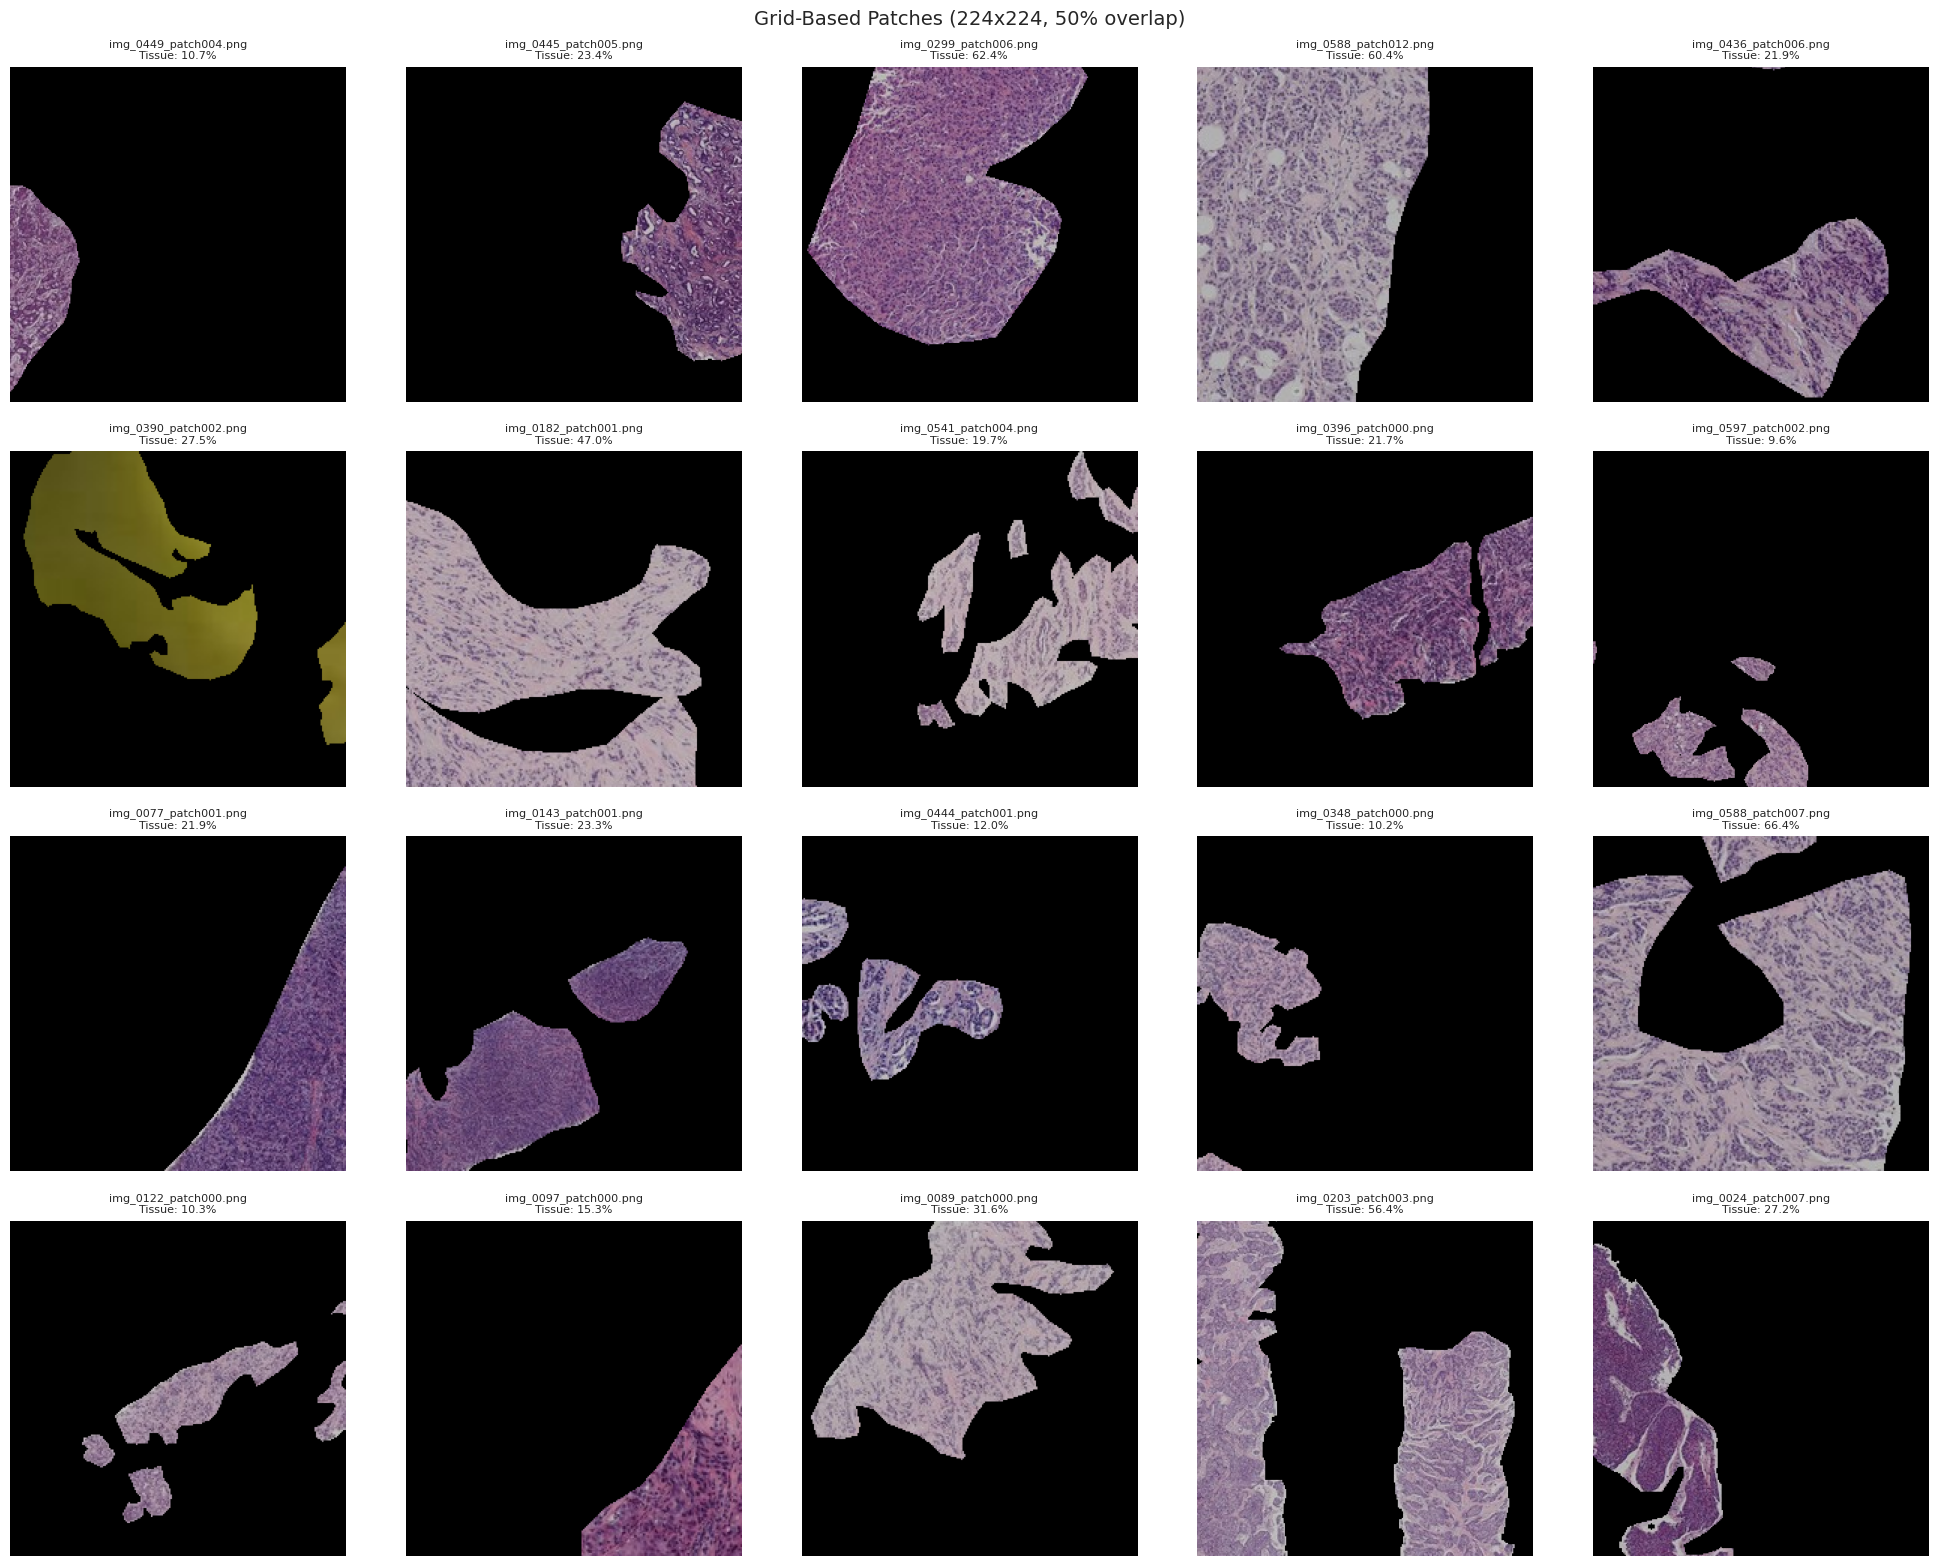

In [24]:
# Call the previous functions to create the patches dataset and show some examples

source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)
indx_eliminated = []

# if not source_dir.exists():
# 	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
# 	source_dir.mkdir(parents=True, exist_ok=True)

# output_dir.mkdir(parents=True, exist_ok=True)

MASKED_IMAGE_PATH = str(output_dir)

PATCH_SIZE = Target_dimension # Corrected: Use Target_dimension for consistency
source_dir = Path(SOURCE_FOLDER)

# Create folder for grid-based patches
patched_output_dir = source_dir.parent / "train_data_patched_grid"
patched_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Source directory: {source_dir}")
print(f"Output directory for grid patches: {patched_output_dir}")

# Compute kept indices after eliminating the shrek images
all_indices = set(range(len(os.listdir(MASKED_IMAGE_PATH))))
kept_indices = sorted(list(all_indices - set(indx_eliminated)))

# Create grid patches with 50% overlap and 15% minimum tissue content
df_patches = create_grid_patched_dataset(
    source_dir=source_dir,
    output_dir=patched_output_dir,
    patch_size=PATCH_SIZE,
    overlap=0.05,  # 5% overlap between adjacent patches
    min_tissue_ratio=0.10,  # Keep patches with at least 10% tissue
    kept_indices=kept_indices  # Only process non-eliminated images
)

# Visualize some patches
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"\nTotal patches created (from patch_files length): {len(patch_files)}")

# Show random samples
if len(patch_files) > 0:
    num_samples = min(20, len(patch_files))
    sample_indices = np.random.choice(len(patch_files), num_samples, replace=False)

    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):
        patch_img = cv2.imread(str(patch_files[idx]))
        if patch_img is not None:
            patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)

            # Calculate tissue content
            non_black = np.sum(patch_rgb.sum(axis=2) > 30)
            tissue_pct = (non_black / (PATCH_SIZE*PATCH_SIZE)) * 100

            axes[i].imshow(patch_rgb)
            axes[i].set_title(f"{patch_files[idx].name}\nTissue: {tissue_pct:.1f}%", fontsize=8)
            axes[i].axis('off')

    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Grid-Based Patches (224x224, 50% overlap)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [25]:
# Apply HSV filtering to the patches as well
print(f"\nApplying HSV filtering to patches in {patched_output_dir}...")

patch_files = sorted(list(patched_output_dir.glob("*.png")))

for patch_path in tqdm(patch_files, desc="Filtering patches"):
    patch_img = cv2.imread(str(patch_path))
    if patch_img is None:
        tqdm.write(f"Error: Could not load patch {patch_path}")
        continue

    # Convert from BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0

    # Apply the filtering
    filtered_bgr, _ = filter_bright_green_areas(patch_rgb)

    # Convert back to BGR for saving
    filtered_bgr_save = filtered_bgr

    # Save the filtered patch back
    cv2.imwrite(str(patch_path), filtered_bgr_save)


Applying HSV filtering to patches in /gdrive/My Drive/AN2DL Challenge 2/train_data_patched_grid...


Filtering patches: 100%|██████████| 1762/1762 [00:32<00:00, 53.97it/s]


In [26]:
def filter_black_ratio(patch_dir, threshold_black_ratio=0.90, black_thr=20):
    """
    Removes patches where more than `threshold_black_ratio`
    of pixels are black/dark.

    threshold_black_ratio: float between 0 and 1.
    black_thr: RGB cutoff to consider a pixel 'black'.
    """
    patch_dir = Path(patch_dir)
    patch_files = sorted(list(patch_dir.glob("*.png")))

    kept_files = []
    removed_files = []

    for patch_file in patch_files:
        img = np.array(Image.open(patch_file))

        # Compute black mask
        black_mask = (
            (img[:,:,0] < black_thr) &
            (img[:,:,1] < black_thr) &
            (img[:,:,2] < black_thr)
        )

        black_ratio = black_mask.mean()   # fraction of black pixels

        if black_ratio > threshold_black_ratio:
            removed_files.append((patch_file, black_ratio))
            patch_file.unlink()  # delete file
        else:
            kept_files.append((patch_file, black_ratio))

    print("\nFiltering complete.")
    print(f"Total patches: {len(patch_files)}")
    print(f"Removed patches: {len(removed_files)}")
    print(f"Remaining patches: {len(kept_files)}")

    if removed_files:
        print("\nSome removed patch stats:")
        for f, r in removed_files[:10]:
            print(f"  {f.name}: black_ratio={r:.3f}")

    return kept_files, removed_files


In [27]:
kept, removed = filter_black_ratio(
    patched_output_dir,
    threshold_black_ratio=0.95,  # allow up to 95% black pixels
    black_thr=20                 # pixel considered "black" if < 20
)


Filtering complete.
Total patches: 1762
Removed patches: 269
Remaining patches: 1493

Some removed patch stats:
  img_0001_patch000.png: black_ratio=1.000
  img_0001_patch001.png: black_ratio=1.000
  img_0001_patch002.png: black_ratio=1.000
  img_0005_patch000.png: black_ratio=1.000
  img_0005_patch001.png: black_ratio=1.000
  img_0005_patch002.png: black_ratio=1.000
  img_0008_patch000.png: black_ratio=1.000
  img_0012_patch000.png: black_ratio=1.000
  img_0012_patch001.png: black_ratio=0.966
  img_0012_patch002.png: black_ratio=1.000



Removed Patches Analysis

Total removed patches: 269

Black ratio statistics for removed patches:
  Min black ratio: 0.955
  Max black ratio: 1.000
  Mean black ratio: 0.998
  Median black ratio: 1.000

First 20 removed patches:
  img_0001_patch000.png: black_ratio=1.000
  img_0001_patch001.png: black_ratio=1.000
  img_0001_patch002.png: black_ratio=1.000
  img_0005_patch000.png: black_ratio=1.000
  img_0005_patch001.png: black_ratio=1.000
  img_0005_patch002.png: black_ratio=1.000
  img_0008_patch000.png: black_ratio=1.000
  img_0012_patch000.png: black_ratio=1.000
  img_0012_patch001.png: black_ratio=0.966
  img_0012_patch002.png: black_ratio=1.000
  img_0012_patch003.png: black_ratio=1.000
  img_0018_patch006.png: black_ratio=1.000
  img_0018_patch007.png: black_ratio=1.000
  img_0020_patch000.png: black_ratio=1.000
  img_0020_patch001.png: black_ratio=1.000
  img_0020_patch002.png: black_ratio=1.000
  img_0020_patch003.png: black_ratio=1.000
  img_0028_patch000.png: black_ratio=1.

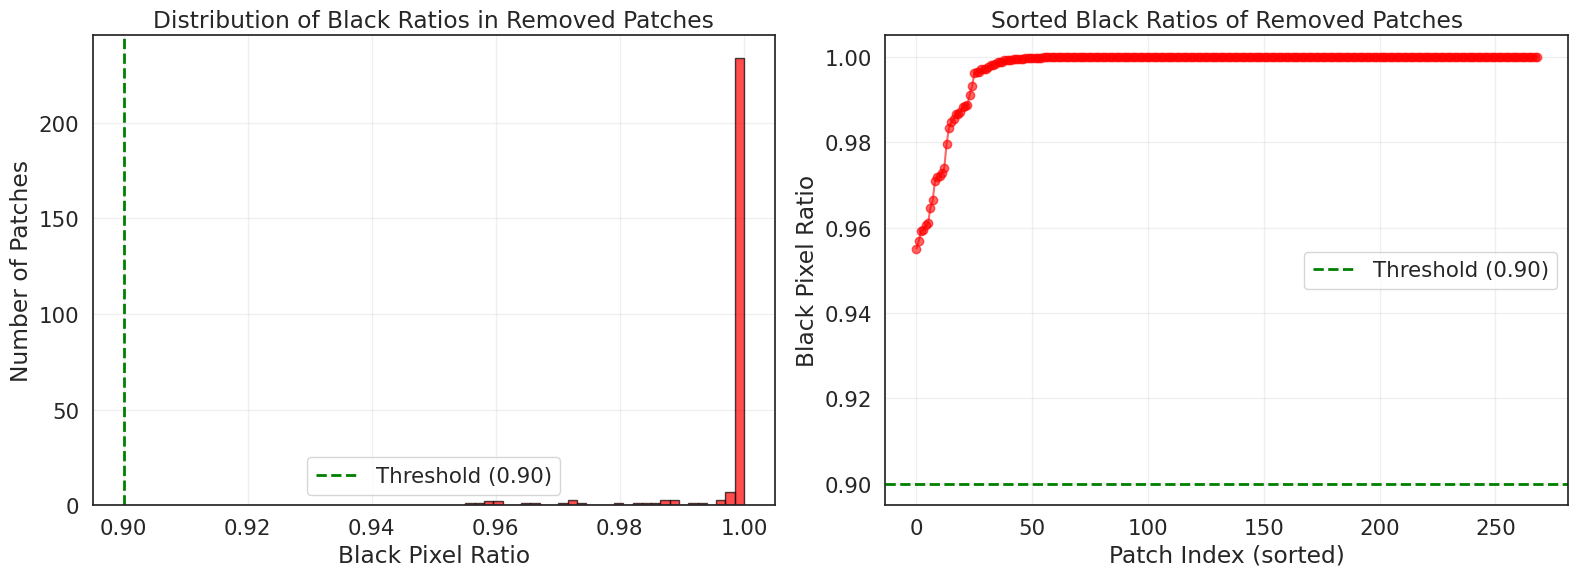

In [28]:
# Visualize statistics about removed patches (files already deleted)
print(f"\n{'='*60}")
print(f"Removed Patches Analysis")
print(f"{'='*60}")

if len(removed) > 0:
    # Extract filenames and black ratios
    removed_names = [f.name for f, _ in removed]
    removed_ratios = [ratio for _, ratio in removed]

    print(f"\nTotal removed patches: {len(removed)}")
    print(f"\nBlack ratio statistics for removed patches:")
    print(f"  Min black ratio: {min(removed_ratios):.3f}")
    print(f"  Max black ratio: {max(removed_ratios):.3f}")
    print(f"  Mean black ratio: {np.mean(removed_ratios):.3f}")
    print(f"  Median black ratio: {np.median(removed_ratios):.3f}")

    # Show first 20 removed patch names
    num_to_show = min(20, len(removed))
    print(f"\nFirst {num_to_show} removed patches:")
    for i in range(num_to_show):
        patch_file, black_ratio = removed[i]
        print(f"  {patch_file.name}: black_ratio={black_ratio:.3f}")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Histogram of black ratios
    axes[0].hist(removed_ratios, bins=30, color='red', alpha=0.7, edgecolor='black')
    axes[0].axvline(0.90, color='green', linestyle='--', linewidth=2, label='Threshold (0.90)')
    axes[0].set_xlabel('Black Pixel Ratio')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Distribution of Black Ratios in Removed Patches')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Sorted black ratios
    sorted_ratios = sorted(removed_ratios)
    axes[1].plot(range(len(sorted_ratios)), sorted_ratios, 'o-', color='red', alpha=0.6)
    axes[1].axhline(0.90, color='green', linestyle='--', linewidth=2, label='Threshold (0.90)')
    axes[1].set_xlabel('Patch Index (sorted)')
    axes[1].set_ylabel('Black Pixel Ratio')
    axes[1].set_title('Sorted Black Ratios of Removed Patches')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo patches were removed.")

## SPLIT THE DATASET


Creating Patch-to-Label Mapping CSV

Original labels CSV contains 691 entries
Created mapping for 691 original images
Found 1493 patch files in train_data_patched_grid


Mapping patches to labels: 100%|██████████| 1493/1493 [00:00<00:00, 192366.17it/s]


Mapping Results
Successfully labeled patches: 1493
Unlabeled patches: 0
Total patches: 1493



Saved patch labels to: /gdrive/My Drive/AN2DL Challenge 2/train_labels_patched.csv

Sample of patched labels CSV:
                filename  original_img_number      label
0  img_0002_patch000.png                    2  Luminal B
1  img_0003_patch000.png                    3  Luminal B
2  img_0003_patch001.png                    3  Luminal B
3  img_0006_patch000.png                    6  Luminal A
4  img_0009_patch000.png                    9  Luminal B
5  img_0009_patch001.png                    9  Luminal B
6  img_0009_patch002.png                    9  Luminal B
7  img_0009_patch003.png                    9  Luminal B
8  img_0009_patch004.png                    9  Luminal B
9  img_0009_patch005.png                    9  Luminal B

Label Distribution Across Patches
  HER2(+): 363 patches (24.31%)
  Luminal A: 378 patches (25.32%)
  Luminal B: 566 patches (37.91%)
  Triple negative: 186 patches (12.46%)


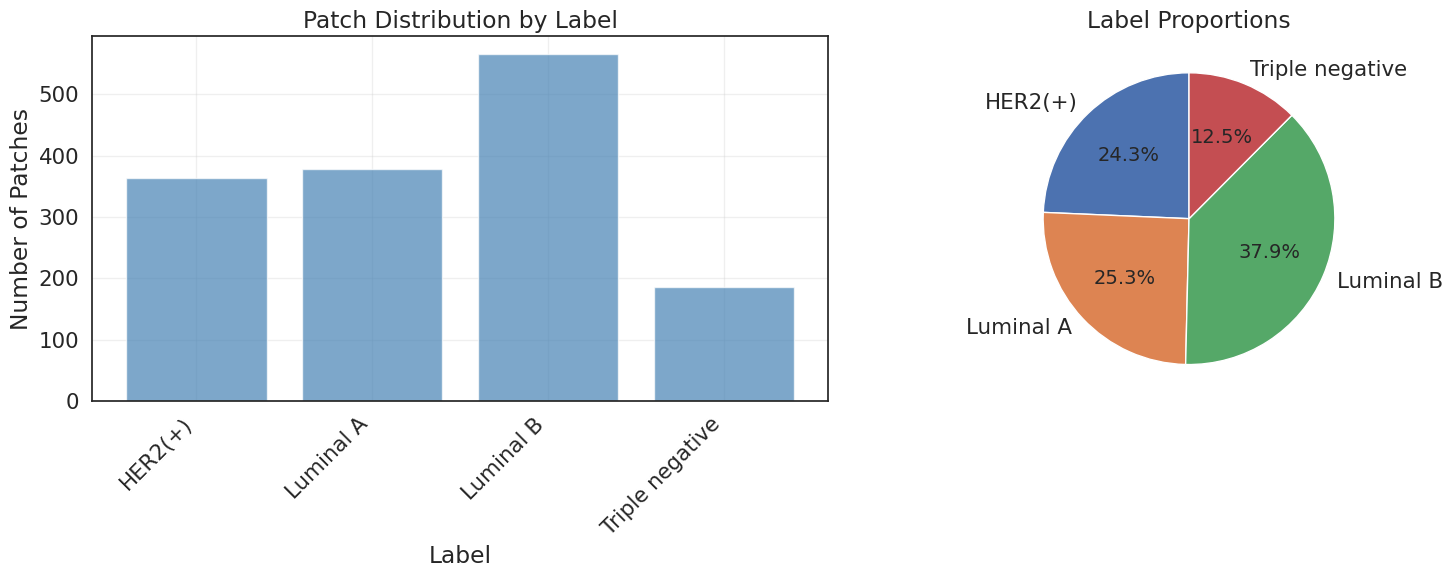


Patches Per Original Image Statistics
  Number of original images with patches: 481
  Min patches per image: 1
  Max patches per image: 17
  Mean patches per image: 3.10
  Median patches per image: 3


In [29]:
# Create a new CSV file mapping patches to labels based on original image indices
from typing import Counter

print(f"\n{'='*60}")
print(f"Creating Patch-to-Label Mapping CSV")
print(f"{'='*60}")

# Load original labels
original_labels_df = pd.read_csv(CSV_PATH)
print(f"\nOriginal labels CSV contains {len(original_labels_df)} entries")

# Create a mapping dictionary: image_number -> label
# The CSV format is: img_XXXX.jpg, label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0]  # e.g., "img_0042.jpg"
    label = row.iloc[1]      # e.g., "Tomato___Late_blight"

    # Extract the image number from filename
    # "img_0042.jpg" -> 42
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Get all patch files from the patched directory
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} patch files in {patched_output_dir.name}")

# Create lists to store patch data
patch_data = []
labeled_count = 0
unlabeled_count = 0
label_distribution = Counter()

# Process each patch file
for patch_file in tqdm(patch_files, desc="Mapping patches to labels"):
    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    filename = patch_file.stem  # Remove .png -> "img_0042_patch03"
    parts = filename.split('_')

    if len(parts) >= 3:
        try:
            # Extract the image number (e.g., "0042" -> 42)
            original_img_number = int(parts[1])
            patch_number = parts[2]  # e.g., "patch03"

            # Look up the label for this original image
            if original_img_number in image_to_label:
                label = image_to_label[original_img_number]

                # Store patch filename and label
                patch_data.append({
                    'filename': patch_file.name,  # e.g., "img_0042_patch03.png"
                    'original_img_number': original_img_number,
                    'label': label
                })

                labeled_count += 1
                label_distribution[label] += 1
            else:
                unlabeled_count += 1
                tqdm.write(f"Warning: No label found for image number {original_img_number}")
        except (ValueError, IndexError) as e:
            tqdm.write(f"Warning: Could not parse filename {patch_file.name}: {e}")
            unlabeled_count += 1
    else:
        tqdm.write(f"Warning: Unexpected filename format: {patch_file.name}")
        unlabeled_count += 1

# Create DataFrame from patch data
patches_df = pd.DataFrame(patch_data)

print(f"\n{'='*60}")
print(f"Mapping Results")
print(f"{'='*60}")
print(f"Successfully labeled patches: {labeled_count}")
print(f"Unlabeled patches: {unlabeled_count}")
print(f"Total patches: {len(patch_files)}")

if labeled_count > 0:
    # Save to new CSV file
    patches_csv_path = os.path.join(datasets_path, "train_labels_patched.csv")
    patches_df.to_csv(patches_csv_path, index=False)
    print(f"\nSaved patch labels to: {patches_csv_path}")

    # Display sample of the CSV
    print(f"\nSample of patched labels CSV:")
    print(patches_df.head(10))

    # Show label distribution
    print(f"\n{'='*60}")
    print(f"Label Distribution Across Patches")
    print(f"{'='*60}")
    for label, count in sorted(label_distribution.items()):
        percentage = (count / labeled_count) * 100
        print(f"  {label}: {count} patches ({percentage:.2f}%)")

    # Visualize label distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart
    labels_sorted = sorted(label_distribution.keys())
    counts_sorted = [label_distribution[l] for l in labels_sorted]

    axes[0].bar(range(len(labels_sorted)), counts_sorted, color='steelblue', alpha=0.7)
    axes[0].set_xticks(range(len(labels_sorted)))
    axes[0].set_xticklabels(labels_sorted, rotation=45, ha='right')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Patch Distribution by Label')
    axes[0].grid(True, alpha=0.3)

    # Pie chart
    axes[1].pie(counts_sorted, labels=labels_sorted, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Label Proportions')

    plt.tight_layout()
    plt.show()

    # Show patches per original image statistics
    patches_per_image = patches_df.groupby('original_img_number').size()
    print(f"\n{'='*60}")
    print(f"Patches Per Original Image Statistics")
    print(f"{'='*60}")
    print(f"  Number of original images with patches: {len(patches_per_image)}")
    print(f"  Min patches per image: {patches_per_image.min()}")
    print(f"  Max patches per image: {patches_per_image.max()}")
    print(f"  Mean patches per image: {patches_per_image.mean():.2f}")
    print(f"  Median patches per image: {patches_per_image.median():.0f}")

else:
    print("\nError: No patches were successfully labeled!")



Aligning Patched Images with Labels (Split by Original Images)

Loaded 691 original image labels from CSV
Created mapping for 691 original images
Loaded 1493 patch-label mappings

Splitting Original Images (to prevent data leakage)
Number of original images with patches: 481

Original image split:
  Training images: 336
  Validation images: 130
  Test images: 15

Assigning Patches to Splits
Found 1493 total patch files


Loading and splitting patches:   0%|          | 0/1493 [00:00<?, ?it/s]

Loading and splitting patches:   1%|          | 16/1493 [00:00<00:09, 153.26it/s]

Loading and splitting patches:   1%|          | 16/1493 [00:00<00:09, 153.26it/s]

Loading and splitting patches:   2%|▏         | 32/1493 [00:00<00:12, 117.22it/s]

Loading and splitting patches:   2%|▏         | 32/1493 [00:00<00:12, 117.22it/s]

Loading and splitting patches:   3%|▎         | 45/1493 [00:00<00:13, 110.39it/s]

Loading and splitting patches:   3%|▎         | 45/1493 [00:00<00:13, 110.39it/s]

Loading and splitting patches:   4%|▍         | 57/1493 [00:00<00:13, 103.08it/s]

Loading and splitting patches:   5%|▍         | 69/1493 [00:00<00:13, 107.97it/s]

Loading and splitting patches:   5%|▍         | 69/1493 [00:00<00:13, 107.97it/s]

Loading and splitting patches:   5%|▌         | 80/1493 [00:00<00:14, 100.55it/s]

Loading and splitting patches:   6%|▌         | 92/1493 [00:00<00:13, 105.69it/s]

Loading and splitting patches:   7%|▋         | 103/1493 [00:00<00:13, 103.60it/s]

Loading and splitting patches:   8%|▊         | 125/1493 [00:01<00:14, 96.88it/s]

Loading and splitting patches:   9%|▉         | 136/1493 [00:01<00:13, 99.25it/s]

Loading and splitting patches:   9%|▉         | 136/1493 [00:01<00:13, 99.25it/s]

Loading and splitting patches:  10%|█         | 156/1493 [00:01<00:14, 95.18it/s]

Loading and splitting patches:  10%|█         | 156/1493 [00:01<00:14, 95.18it/s]

Loading and splitting patches:  12%|█▏        | 177/1493 [00:01<00:13, 98.36it/s]

Loading and splitting patches:  12%|█▏        | 177/1493 [00:01<00:13, 98.36it/s]

Loading and splitting patches:  13%|█▎        | 187/1493 [00:01<00:14, 92.78it/s]

Loading and splitting patches:  14%|█▍        | 211/1493 [00:02<00:12, 102.58it/s]

Loading and splitting patches:  17%|█▋        | 247/1493 [00:02<00:12, 103.69it/s]

Loading and splitting patches:  18%|█▊        | 270/1493 [00:02<00:11, 106.50it/s]

Loading and splitting patches:  20%|█▉        | 298/1493 [00:02<00:09, 119.87it/s]

Loading and splitting patches:  22%|██▏       | 323/1493 [00:03<00:10, 113.67it/s]

Loading and splitting patches:  23%|██▎       | 346/1493 [00:03<00:10, 107.82it/s]

Loading and splitting patches:  24%|██▍       | 357/1493 [00:03<00:11, 101.42it/s]

Loading and splitting patches:  25%|██▌       | 378/1493 [00:03<00:11, 93.54it/s]

Loading and splitting patches:  27%|██▋       | 399/1493 [00:03<00:11, 93.83it/s]

Loading and splitting patches:  28%|██▊       | 421/1493 [00:04<00:11, 92.33it/s]

Loading and splitting patches:  30%|██▉       | 441/1493 [00:04<00:11, 89.50it/s]

Loading and splitting patches:  31%|███       | 461/1493 [00:04<00:11, 86.57it/s]

Loading and splitting patches:  32%|███▏      | 482/1493 [00:04<00:11, 86.87it/s]

Loading and splitting patches:  34%|███▍      | 504/1493 [00:05<00:11, 89.20it/s]

Loading and splitting patches:  35%|███▌      | 529/1493 [00:05<00:09, 101.77it/s]

Loading and splitting patches:  37%|███▋      | 552/1493 [00:05<00:08, 106.62it/s]

Loading and splitting patches:  39%|███▊      | 575/1493 [00:05<00:08, 103.50it/s]

Loading and splitting patches:  40%|████      | 601/1493 [00:05<00:07, 113.69it/s]

Loading and splitting patches:  42%|████▏     | 625/1493 [00:06<00:07, 113.44it/s]

Loading and splitting patches:  44%|████▍     | 663/1493 [00:06<00:06, 120.33it/s]

Loading and splitting patches:  46%|████▌     | 688/1493 [00:06<00:07, 107.48it/s]

Loading and splitting patches:  48%|████▊     | 713/1493 [00:06<00:06, 113.62it/s]

Loading and splitting patches:  49%|████▉     | 738/1493 [00:07<00:06, 114.93it/s]

Loading and splitting patches:  54%|█████▎    | 802/1493 [00:07<00:06, 111.78it/s]

Loading and splitting patches:  55%|█████▌    | 826/1493 [00:07<00:05, 113.50it/s]

Loading and splitting patches:  57%|█████▋    | 851/1493 [00:08<00:05, 111.62it/s]

Loading and splitting patches:  60%|█████▉    | 892/1493 [00:08<00:04, 121.09it/s]

Loading and splitting patches:  61%|██████    | 907/1493 [00:08<00:04, 125.26it/s]

Loading and splitting patches:  63%|██████▎   | 945/1493 [00:08<00:04, 116.38it/s]

Loading and splitting patches:  64%|██████▍   | 957/1493 [00:09<00:04, 112.66it/s]

Loading and splitting patches:  67%|██████▋   | 994/1493 [00:09<00:04, 113.91it/s]

Loading and splitting patches:  68%|██████▊   | 1020/1493 [00:09<00:04, 116.22it/s]

Loading and splitting patches:  70%|██████▉   | 1044/1493 [00:09<00:04, 111.83it/s]

Loading and splitting patches:  72%|███████▏  | 1068/1493 [00:10<00:03, 113.53it/s]

Loading and splitting patches:  73%|███████▎  | 1092/1493 [00:10<00:03, 112.04it/s]

Loading and splitting patches:  75%|███████▍  | 1115/1493 [00:10<00:03, 104.93it/s]

Loading and splitting patches:  76%|███████▋  | 1140/1493 [00:10<00:03, 109.97it/s]

Loading and splitting patches:  78%|███████▊  | 1164/1493 [00:11<00:03, 108.99it/s]

Loading and splitting patches:  80%|███████▉  | 1190/1493 [00:11<00:02, 108.75it/s]

Loading and splitting patches:  82%|████████▏ | 1228/1493 [00:11<00:02, 116.24it/s]

Loading and splitting patches:  83%|████████▎ | 1240/1493 [00:11<00:02, 108.68it/s]

Loading and splitting patches:  85%|████████▍ | 1263/1493 [00:11<00:02, 103.59it/s]

Loading and splitting patches:  86%|████████▋ | 1289/1493 [00:12<00:01, 106.23it/s]

Loading and splitting patches:  88%|████████▊ | 1314/1493 [00:12<00:01, 114.84it/s]

Loading and splitting patches:  90%|████████▉ | 1343/1493 [00:12<00:01, 126.00it/s]

Loading and splitting patches:  92%|█████████▏| 1369/1493 [00:12<00:01, 119.11it/s]

Loading and splitting patches:  93%|█████████▎| 1395/1493 [00:12<00:00, 118.18it/s]

Loading and splitting patches:  95%|█████████▌| 1419/1493 [00:13<00:00, 116.81it/s]

Loading and splitting patches:  97%|█████████▋| 1443/1493 [00:13<00:00, 116.03it/s]

Loading and splitting patches:  98%|█████████▊| 1467/1493 [00:13<00:00, 109.10it/s]

Loading and splitting patches: 100%|██████████| 1493/1493 [00:13<00:00, 107.88it/s]



Split Results
Skipped patches: 552
Total patches loaded: 941

Label Encoding
Number of unique classes: 4
Classes: [np.str_('HER2(+)'), np.str_('Luminal A'), np.str_('Luminal B'), np.str_('Triple negative')]

Dataset Statistics

Training set:
  Images: (649, 224, 224, 3)
  Labels: (649,)
  Patches per original image (avg): 1.93
  Class distribution: [146 178 257  68]

Validation set:
  Images: (250, 224, 224, 3)
  Labels: (250,)
  Patches per original image (avg): 1.92
  Class distribution: [57 50 99 44]

Test set:
  Images: (42, 224, 224, 3)
  Labels: (42,)
  Patches per original image (avg): 2.80
  Class distribution: [15  7 17  3]

Class Distribution Across Splits

HER2(+) (class 0):
  Train: 146 (67.0%)
  Val:   57 (26.1%)
  Test:  15 (6.9%)

Luminal A (class 1):
  Train: 178 (75.7%)
  Val:   50 (21.3%)
  Test:  7 (3.0%)

Luminal B (class 2):
  Train: 257 (68.9%)
  Val:   99 (26.5%)
  Test:  17 (4.6%)

Triple negative (class 3):
  Train: 68 (59.1%)
  Val:   44 (38.3%)
  Test:  3 (2

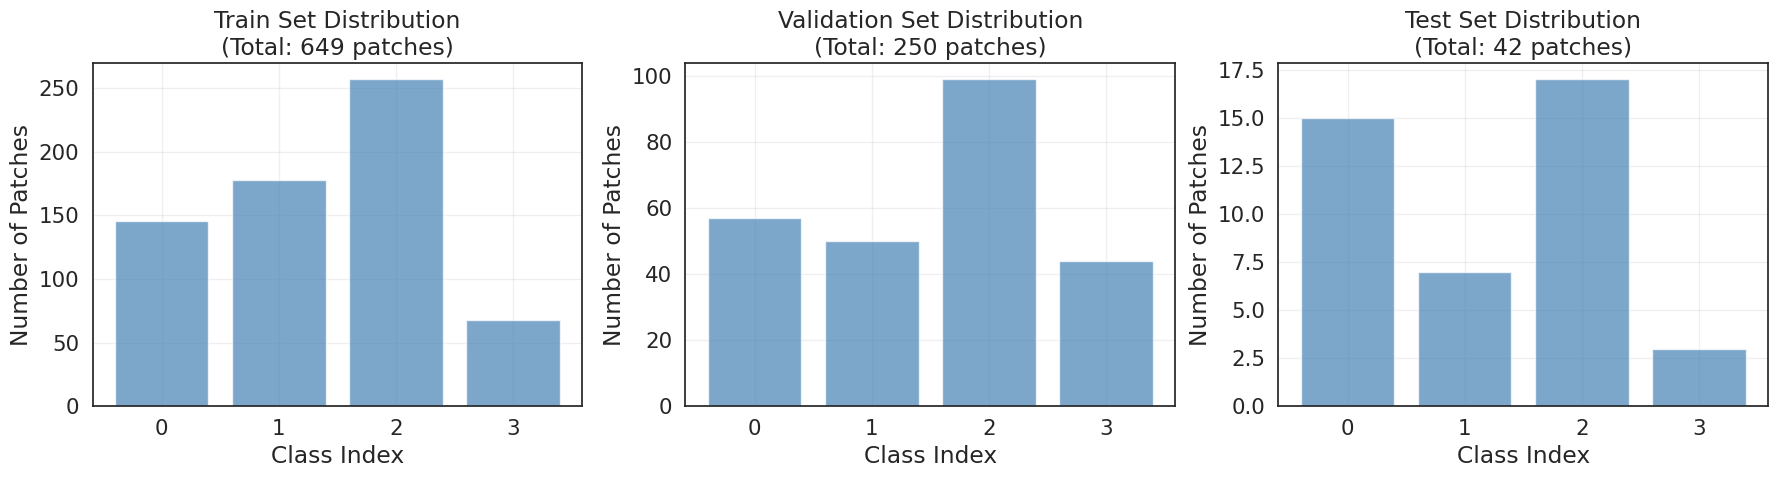


Dataset preparation complete!
No data leakage: Each original image's patches are in only ONE split


In [30]:
from sklearn.preprocessing import LabelEncoder

print(f"\n{'='*60}")
print(f"Aligning Patched Images with Labels (Split by Original Images)")
print(f"{'='*60}")

# Load the ORIGINAL labels CSV (not the patched one)
original_csv_path = Path(datasets_path) / "train_labels.csv"
if not original_csv_path.exists():
    raise FileNotFoundError(f"Original labels CSV not found at {original_csv_path}")

original_labels_df = pd.read_csv(original_csv_path)
print(f"\nLoaded {len(original_labels_df)} original image labels from CSV")

# Create mapping: image_number -> label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0]
    label = row.iloc[1]
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Load the patched labels CSV to get all patches
patches_csv_path = Path(datasets_path) / "train_labels_patched.csv"
if not patches_csv_path.exists():
    raise FileNotFoundError(f"Patched labels CSV not found at {patches_csv_path}")

patches_df = pd.read_csv(patches_csv_path)
print(f"Loaded {len(patches_df)} patch-label mappings")

# STEP 1: Split at the ORIGINAL IMAGE LEVEL
print(f"\n{'='*60}")
print(f"Splitting Original Images (to prevent data leakage)")
print(f"{'='*60}")

# Get unique original image numbers that have patches
original_img_numbers = patches_df['original_img_number'].unique()
print(f"Number of original images with patches: {len(original_img_numbers)}")

# Get labels for these images
original_labels = [image_to_label[img_num] for img_num in original_img_numbers]

# Encode labels for stratification
label_encoder = LabelEncoder()
original_labels_encoded = label_encoder.fit_transform(original_labels)

# Split original images into train/temp (80/20)
train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
    original_img_numbers,
    original_labels_encoded,
    test_size=0.3,
    random_state=SEED,
    stratify=original_labels_encoded
)

# Split temp into val/test (50/50 of temp = 10/10 of total)
val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
    temp_img_nums,
    temp_img_labels,
    test_size=0.1,
    random_state=SEED,
    stratify=temp_img_labels
)

print(f"\nOriginal image split:")
print(f"  Training images: {len(train_img_nums)}")
print(f"  Validation images: {len(val_img_nums)}")
print(f"  Test images: {len(test_img_nums)}")

# STEP 2: Assign patches to splits based on their original image
print(f"\n{'='*60}")
print(f"Assigning Patches to Splits")
print(f"{'='*60}")

train_img_set = set(train_img_nums)
val_img_set = set(val_img_nums)
test_img_set = set(test_img_nums)

# Get all patch files
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} total patch files")

# Create a dictionary for fast lookup: filename -> label
patch_to_label = dict(zip(patches_df['filename'], patches_df['label']))

# Separate patches into train/val/test based on original image
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

skipped_count = 0

for patch_file in tqdm(patch_files, desc="Loading and splitting patches"):
    patch_filename = patch_file.name

    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    parts = patch_filename.split('_')
    if len(parts) < 3:
        skipped_count += 1
        continue

    try:
        original_img_number = int(parts[1])
    except ValueError:
        skipped_count += 1
        continue

    # Look up the label
    if patch_filename not in patch_to_label:
        skipped_count += 1
        continue

    label = patch_to_label[patch_filename]

    # Load the patch image
    patch_img = cv2.imread(str(patch_file))
    if patch_img is None:
        tqdm.write(f"Warning: Could not load {patch_filename}")
        skipped_count += 1
        continue

    # Convert BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0

    # Debugging: Check the shape of the patch before appending
    if patch_rgb.shape != (Target_dimension, Target_dimension, 3):
        tqdm.write(f"Warning: Patch {patch_filename} has unexpected shape: {patch_rgb.shape}. Skipping.")
        skipped_count += 1
        continue

    # Assign to appropriate split based on original image number
    if original_img_number in train_img_set:
        X_train_list.append(patch_rgb)
        y_train_list.append(label)
    elif original_img_number in val_img_set:
        X_val_list.append(patch_rgb)
        y_val_list.append(label)
    elif original_img_number in test_img_set:
        X_test_list.append(patch_rgb)
        y_test_list.append(label)
    else:
        skipped_count += 1

# Convert to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"\n{'='*60}")
print(f"Split Results")
print(f"{'='*60}")
print(f"Skipped patches: {skipped_count}")
print(f"Total patches loaded: {len(X_train) + len(X_val) + len(X_test)}")

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Print class mapping
print(f"\n{'='*60}")
print(f"Label Encoding")
print(f"{'='*60}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

# Show split statistics
print(f"\n{'='*60}")
print(f"Dataset Statistics")
print(f"{'='*60}")

print(f"\nTraining set:")
print(f"  Images: {X_train.shape}")
print(f"  Labels: {y_train_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_train) / len(train_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_train_encoded)}")

print(f"\nValidation set:")
print(f"  Images: {X_val.shape}")
print(f"  Labels: {y_val_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_val) / len(val_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_val_encoded)}")

print(f"\nTest set:")
print(f"  Images: {X_test.shape}")
print(f"  Labels: {y_test_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_test) / len(test_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_test_encoded)}")

# Show label distribution across splits
unique_train, counts_train = np.unique(y_train_encoded, return_counts=True)
unique_val, counts_val = np.unique(y_val_encoded, return_counts=True)
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)

print(f"\n{'='*60}")
print(f"Class Distribution Across Splits")
print(f"{'='*60}")
for class_idx in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[class_idx]
    train_count = counts_train[class_idx] if class_idx in unique_train else 0
    val_count = counts_val[class_idx] if class_idx in unique_val else 0
    test_count = counts_test[class_idx] if class_idx in unique_test else 0
    total = train_count + val_count + test_count

    print(f"\n{class_name} (class {class_idx}):")
    print(f"  Train: {train_count} ({train_count/total*100:.1f}%)")
    print(f"  Val:   {val_count} ({val_count/total*100:.1f}%)")
    print(f"  Test:  {test_count} ({test_count/total*100:.1f}%)")

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, split_labels) in enumerate([
    ('Train', y_train_encoded),
    ('Validation', y_val_encoded),
    ('Test', y_test_encoded)
]):
    class_counts = np.bincount(split_labels)
    axes[idx].bar(range(len(class_counts)), class_counts, color='steelblue', alpha=0.7)
    axes[idx].set_xlabel('Class Index')
    axes[idx].set_ylabel('Number of Patches')
    axes[idx].set_title(f'{split_name} Set Distribution\n(Total: {len(split_labels)} patches)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update the global variables to use encoded labels
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

print(f"\n{'='*60}")
print(f"Dataset preparation complete!")
print(f"No data leakage: Each original image's patches are in only ONE split")
print(f"{'='*60}")

In [31]:
# print(f"\n{'='*60}")
# print(f"Aligning Patched Images with Labels (Split by Original Images)")
# print(f"{'='*60}")

# # Load the ORIGINAL labels CSV (not the patched one)
# original_csv_path = Path(datasets_path) / "train_labels.csv"
# if not original_csv_path.exists():
#     raise FileNotFoundError(f"Original labels CSV not found at {original_csv_path}")

# original_labels_df = pd.read_csv(original_csv_path)
# print(f"\nLoaded {len(original_labels_df)} original image labels from CSV")

# # Create mapping: image_number -> label
# image_to_label = {}
# for idx, row in original_labels_df.iterrows():
#     filename = row.iloc[0]
#     label = row.iloc[1]
#     img_number = int(filename.split('_')[1].split('.')[0])
#     image_to_label[img_number] = label

# print(f"Created mapping for {len(image_to_label)} original images")

# # Load the patched labels CSV to get all patches
# patches_csv_path = Path(datasets_path) / "train_labels_patched.csv"
# if not patches_csv_path.exists():
#     raise FileNotFoundError(f"Patched labels CSV not found at {patches_csv_path}")

# patches_df = pd.read_csv(patches_csv_path)
# print(f"Loaded {len(patches_df)} patch-label mappings")

# # STEP 1: Split at the ORIGINAL IMAGE LEVEL
# print(f"\n{'='*60}")
# print(f"Splitting Original Images (to prevent data leakage)")
# print(f"{'='*60}")

# # Get unique original image numbers that have patches
# original_img_numbers = patches_df['original_img_number'].unique()
# print(f"Number of original images with patches: {len(original_img_numbers)}")

# # Get labels for these images
# original_labels = [image_to_label[img_num] for img_num in original_img_numbers]

# # Encode labels for stratification
# label_encoder = LabelEncoder()
# original_labels_encoded = label_encoder.fit_transform(original_labels)

# # Split original images into train/temp (80/20)
# train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
#     original_img_numbers,
#     original_labels_encoded,
#     test_size=0.3,
#     random_state=SEED,
#     stratify=original_labels_encoded
# )

# # Split temp into val/test (50/50 of temp = 10/10 of total)
# val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
#     temp_img_nums,
#     temp_img_labels,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=temp_img_labels
# )

# print(f"\nOriginal image split:")
# print(f"  Training images: {len(train_img_nums)}")
# print(f"  Validation images: {len(val_img_nums)}")
# print(f"  Test images: {len(test_img_nums)}")

# # STEP 2: Assign patches to splits based on their original image
# print(f"\n{'='*60}")
# print(f"Assigning Patches to Splits")
# print(f"{'='*60}")

# train_img_set = set(train_img_nums)
# val_img_set = set(val_img_nums)
# test_img_set = set(test_img_nums)

# # Get all patch files
# patch_files = sorted(list(patched_output_dir.glob("*.png")))
# print(f"Found {len(patch_files)} total patch files")

# # Create a dictionary for fast lookup: filename -> label
# patch_to_label = dict(zip(patches_df['filename'], patches_df['label']))

# # Separate patches into train/val/test based on original image
# X_train_list, y_train_list = [], []
# X_val_list, y_val_list = [], []
# X_test_list, y_test_list = [], []

# skipped_count = 0

# for patch_file in tqdm(patch_files, desc="Loading and splitting patches"):
#     patch_filename = patch_file.name

#     # Extract original image number from patch filename
#     # Format: img_0042_patch03.png
#     parts = patch_filename.split('_')
#     if len(parts) < 3:
#         skipped_count += 1
#         continue

#     try:
#         original_img_number = int(parts[1])
#     except ValueError:
#         skipped_count += 1
#         continue

#     # Look up the label
#     if patch_filename not in patch_to_label:
#         skipped_count += 1
#         continue

#     label = patch_to_label[patch_filename]

#     # Load the patch image
#     patch_img = cv2.imread(str(patch_file))
#     if patch_img is None:
#         tqdm.write(f"Warning: Could not load {patch_filename}")
#         skipped_count += 1
#         continue

#     # Convert BGR to RGB and normalize to [0, 1]
#     patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0

#     # Assign to appropriate split based on original image number
#     if original_img_number in train_img_set:
#         X_train_list.append(patch_rgb)
#         y_train_list.append(label)
#     elif original_img_number in val_img_set:
#         X_val_list.append(patch_rgb)
#         y_val_list.append(label)
#     elif original_img_number in test_img_set:
#         X_test_list.append(patch_rgb)
#         y_test_list.append(label)
#     else:
#         skipped_count += 1

# # Convert to numpy arrays
# X_train = np.array(X_train_list)
# y_train = np.array(y_train_list)
# X_val = np.array(X_val_list)
# y_val = np.array(y_val_list)
# X_test = np.array(X_test_list)
# y_test = np.array(y_test_list)

# print(f"\n{'='*60}")
# print(f"Split Results")
# print(f"{'='*60}")
# print(f"Skipped patches: {skipped_count}")
# print(f"Total patches loaded: {len(X_train) + len(X_val) + len(X_test)}")

# # Encode labels
# y_train_encoded = label_encoder.transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)
# y_test_encoded = label_encoder.transform(y_test)

# # Print class mapping
# print(f"\n{'='*60}")
# print(f"Label Encoding")
# print(f"{'='*60}")
# print(f"Number of unique classes: {len(label_encoder.classes_)}")
# print(f"Classes: {list(label_encoder.classes_)}")

# # Show split statistics
# print(f"\n{'='*60}")
# print(f"Dataset Statistics")
# print(f"{'='*60}")

# print(f"\nTraining set:")
# print(f"  Images: {X_train.shape}")
# print(f"  Labels: {y_train_encoded.shape}")
# print(f"  Patches per original image (avg): {len(X_train) / len(train_img_nums):.2f}")
# print(f"  Class distribution: {np.bincount(y_train_encoded)}")

# print(f"\nValidation set:")
# print(f"  Images: {X_val.shape}")
# print(f"  Labels: {y_val_encoded.shape}")
# print(f"  Patches per original image (avg): {len(X_val) / len(val_img_nums):.2f}")
# print(f"  Class distribution: {np.bincount(y_val_encoded)}")

# print(f"\nTest set:")
# print(f"  Images: {X_test.shape}")
# print(f"  Labels: {y_test_encoded.shape}")
# print(f"  Patches per original image (avg): {len(X_test) / len(test_img_nums):.2f}")
# print(f"  Class distribution: {np.bincount(y_test_encoded)}")

# # Show label distribution across splits
# unique_train, counts_train = np.unique(y_train_encoded, return_counts=True)
# unique_val, counts_val = np.unique(y_val_encoded, return_counts=True)
# unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)

# print(f"\n{'='*60}")
# print(f"Class Distribution Across Splits")
# print(f"{'='*60}")
# for class_idx in range(len(label_encoder.classes_)):
#     class_name = label_encoder.classes_[class_idx]
#     train_count = counts_train[class_idx] if class_idx in unique_train else 0
#     val_count = counts_val[class_idx] if class_idx in unique_val else 0
#     test_count = counts_test[class_idx] if class_idx in unique_test else 0
#     total = train_count + val_count + test_count

#     print(f"\n{class_name} (class {class_idx}):")
#     print(f"  Train: {train_count} ({train_count/total*100:.1f}%)")
#     print(f"  Val:   {val_count} ({val_count/total*100:.1f}%)")
#     print(f"  Test:  {test_count} ({test_count/total*100:.1f}%)")

# # Visualize split distribution
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# for idx, (split_name, split_labels) in enumerate([
#     ('Train', y_train_encoded),
#     ('Validation', y_val_encoded),
#     ('Test', y_test_encoded)
# ]):
#     class_counts = np.bincount(split_labels)
#     axes[idx].bar(range(len(class_counts)), class_counts, color='steelblue', alpha=0.7)
#     axes[idx].set_xlabel('Class Index')
#     axes[idx].set_ylabel('Number of Patches')
#     axes[idx].set_title(f'{split_name} Set Distribution\n(Total: {len(split_labels)} patches)')
#     axes[idx].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Update the global variables to use encoded labels
# y_train = y_train_encoded
# y_val = y_val_encoded
# y_test = y_test_encoded

# print(f"\n{'='*60}")
# print(f"Dataset preparation complete!")
# print(f"No data leakage: Each original image's patches are in only ONE split")
# print(f"{'='*60}")

**Image Augmentation**

In [32]:
# Define a set of transformations for data augmentation and scale the images
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # Resize shorted side → Target_dimension manteining proportions
    transforms.Resize(Target_dimension),
    # Crop random Target_dimension x Target_dimension
    transforms.RandomCrop(Target_dimension),
    # Augmentations
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(Target_dimension),       # Resize in the same way validation and test sets
    transforms.CenterCrop(Target_dimension),
    transforms.ToTensor(),
])

class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [33]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [34]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)

train_ds = AugmentedDataset(X_train, y_train, transform=train_transform)
val_ds   = AugmentedDataset(X_val,   y_val,   transform=val_test_transform)
test_ds  = AugmentedDataset(X_test,  y_test,  transform=val_test_transform)


# train_ds = TensorDataset(
#     torch.from_numpy(X_train).permute(0, 3, 1, 2),
#     torch.from_numpy(y_train).squeeze().long()
# )
# val_ds = TensorDataset(
#     torch.from_numpy(X_val).permute(0, 3, 1, 2),
#     torch.from_numpy(y_val).squeeze().long()
# )
# test_ds = TensorDataset(
#     torch.from_numpy(X_test).permute(0, 3, 1, 2),
#     torch.from_numpy(y_test).squeeze().long()
# )

In [35]:
# Define the batch size
BATCH_SIZE = 32

In [36]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [37]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [38]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


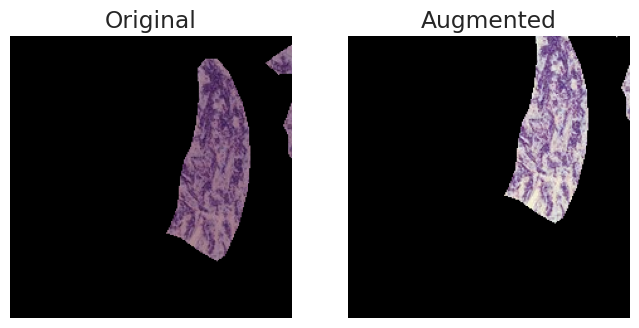

In [39]:
# Plot an original image and its augmented copy
idx = 10  # choose the image to be compared

# Original
original_np = X_train[idx]

# Augmented
augmented_tensor, _ = train_ds[idx]
augmented_np = augmented_tensor.permute(1, 2, 0).numpy()

# Plot
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented")
plt.imshow(augmented_np)
plt.axis("off")

plt.show()

## **4. Network Parameters**

In [40]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 20

# Regularisation
DROPOUT_RATE = 0.2          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 1e-3            # L2 penalty

# Set up loss function and optimizer
#criterion = nn.CrossEntropyLoss()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)  # Set up cost function with weighted losses

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 1000
Batch Size: 32
Learning Rare: 0.001
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0.001


## **4.1 Defining the network structure**

In [41]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 2

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False   # by default stride = 1, so we move the kernel 1 pixel at a time
                     # instead with stride 2 we move by 2 pixels at a time, so it's
                     # like if the kernel jumps from a point of the image to another

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1   # it influences if we take all the image or a bit less or a bit more

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2   # standart practice to start with 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 2
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


In [42]:
# Single convolutional block with multiple conv layers, ReLU and pooling/stride
class VanillaCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=1, use_stride=False, stride_value=2, padding_size=1, pool_size=2):
        super().__init__()

        layers = []

        # First convolution: in_channels -> out_channels
        if num_convs == 1:
            # Single conv: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))
        else:
            # Multiple convs: first one always has stride=1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Intermediate convolutions (all with stride=1)
            for i in range(1, num_convs - 1):
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Last convolution: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1    # by convention the stride is applyed to the last layer
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))

        # ReLU activation
        layers.append(nn.ReLU())

        # Pooling only if not using stride for spatial reduction (if we have used the stride, we have already reduced the dimensionality)
        if not use_stride:
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))   # we need max pooling

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Convolutional Neural Network architecture for CIFAR10 classification
class CNN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10, dropout_rate=DROPOUT_RATE,
                 num_blocks=NUM_BLOCKS, convs_per_block=CONVS_PER_BLOCK,
                 use_stride=USE_STRIDE, stride_value=STRIDE_VALUE, padding_size=PADDING_SIZE, pool_size=POOL_SIZE,
                 initial_channels=INITIAL_CHANNELS, channel_multiplier=CHANNEL_MULTIPLIER):
        super().__init__()

        # Build convolutional blocks
        blocks = []
        in_channels = input_shape[0]
        out_channels = initial_channels

        for i in range(num_blocks):
            blocks.append(VanillaCNNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_convs=convs_per_block,
                use_stride=use_stride,
                stride_value=stride_value,
                padding_size=padding_size,
                pool_size=pool_size
            ))

            # Prepare for next block: increase channels
            in_channels = out_channels
            out_channels = out_channels * channel_multiplier

        self.features = nn.Sequential(*blocks)

        # Calculate flattened size after all blocks using a dummy forward pass
        # This approach is robust and works with any configuration of padding, stride, and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Classification head: flatten features and apply dropout before final layer
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, num_classes)
        )

    # Forward pass through the network
    def forward(self, x):
        x = self.features(x)
        x = self.classifier_head(x)
        return x

In [43]:
# # Instantiate CNN model and move to computing device (CPU/GPU)
# cnn_model = CNN(
#     input_shape,
#     num_classes,
#     num_blocks=NUM_BLOCKS,
#     convs_per_block=CONVS_PER_BLOCK,
#     use_stride=USE_STRIDE,
#     stride_value=STRIDE_VALUE,
#     padding_size=PADDING_SIZE,
#     pool_size=POOL_SIZE,
#     initial_channels=INITIAL_CHANNELS,
#     channel_multiplier=CHANNEL_MULTIPLIER
#     ).to(device)


# IMPORT THE MODEL DENSENET121
# Load DenseNet121 pre-trained on ImageNet
densenet_model = models.densenet121(pretrained=True)

# Replace classifier to match number of classes
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, num_classes)

# Move model to GPU/CPU
densenet_model = densenet_model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(densenet_model.parameters(), lr=1e-4, weight_decay=L2_LAMBDA)

# Optional: learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Display model architecture summary
print(densenet_model)
#summary(densenet_model, input_size=input_shape)

# FINE-TUNING OF THE LAYERS
# Freeze all DenseNet features
for param in densenet_model.features.parameters():
    param.requires_grad = False

# Leave classifier trainable
for param in densenet_model.classifier.parameters():
    param.requires_grad = True

# If we want to unlock also the last DenseBlock for fine-tuning
for name, param in densenet_model.features.named_parameters():
    if "denselayer4" in name:
        param.requires_grad = True

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 130MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [44]:
# Set up TensorBoard logging and save model architecture
experiment_name = "cnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
writer.add_graph(densenet_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(densenet_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

## **Model Training**

In [45]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [46]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [47]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [48]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [49]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [50]:
%%time
# Train model and track training history
densenet_model, training_history = fit(
    model=densenet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="cnn",
    patience=20
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = densenet_model
    best_performance = training_history['val_f1'][-1]

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=1.4745, F1 Score=0.2192 | Val: Loss=1.4250, F1 Score=0.3418
Epoch   2/1000 | Train: Loss=1.3007, F1 Score=0.3953 | Val: Loss=1.4687, F1 Score=0.2511
Epoch   3/1000 | Train: Loss=1.2064, F1 Score=0.4182 | Val: Loss=1.5359, F1 Score=0.2794
Epoch   4/1000 | Train: Loss=1.1433, F1 Score=0.4481 | Val: Loss=1.6437, F1 Score=0.3177
Epoch   5/1000 | Train: Loss=1.0482, F1 Score=0.5004 | Val: Loss=1.8509, F1 Score=0.3005
Epoch   6/1000 | Train: Loss=0.9825, F1 Score=0.5662 | Val: Loss=1.7254, F1 Score=0.2658
Epoch   7/1000 | Train: Loss=0.8944, F1 Score=0.5913 | Val: Loss=1.8999, F1 Score=0.3439
Epoch   8/1000 | Train: Loss=0.8400, F1 Score=0.6638 | Val: Loss=1.9770, F1 Score=0.3406
Epoch   9/1000 | Train: Loss=0.7864, F1 Score=0.6231 | Val: Loss=1.8184, F1 Score=0.2873
Epoch  10/1000 | Train: Loss=0.7457, F1 Score=0.6723 | Val: Loss=2.1314, F1 Score=0.2961
Epoch  11/1000 | Train: Loss=0.6565, F1 Score=0.7124 | Val: Loss=1.9921, F1 Score=0.31

## Show results

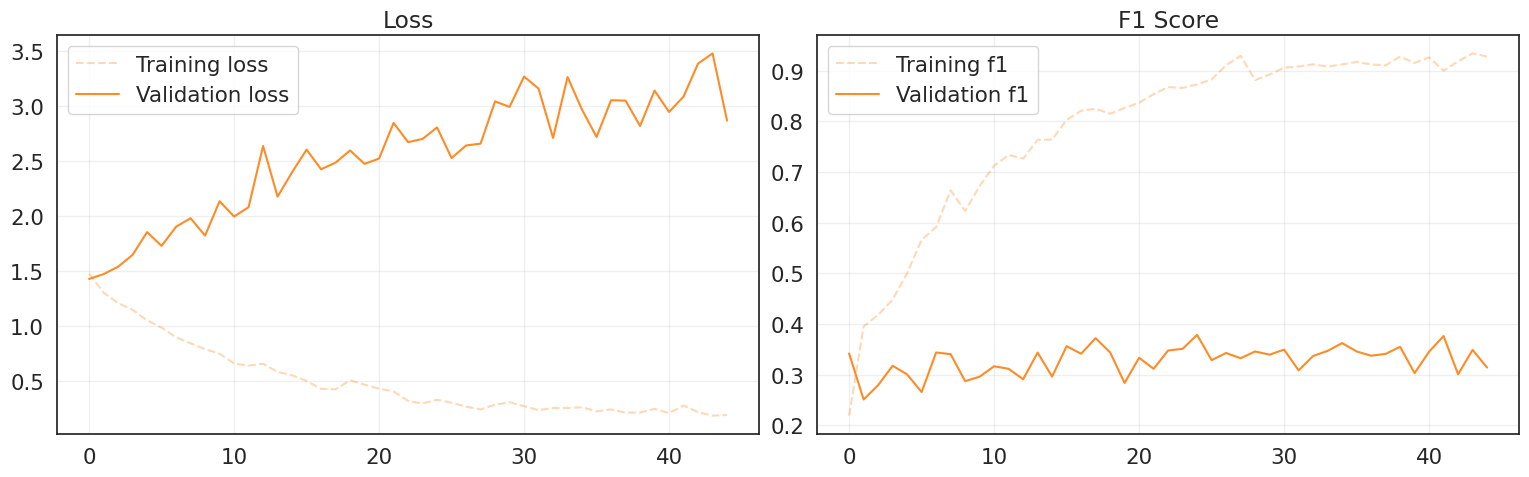

In [51]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.3840
Precision over the validation set: 0.4030
Recall over the validation set: 0.3840
F1 score over the validation set: 0.3737


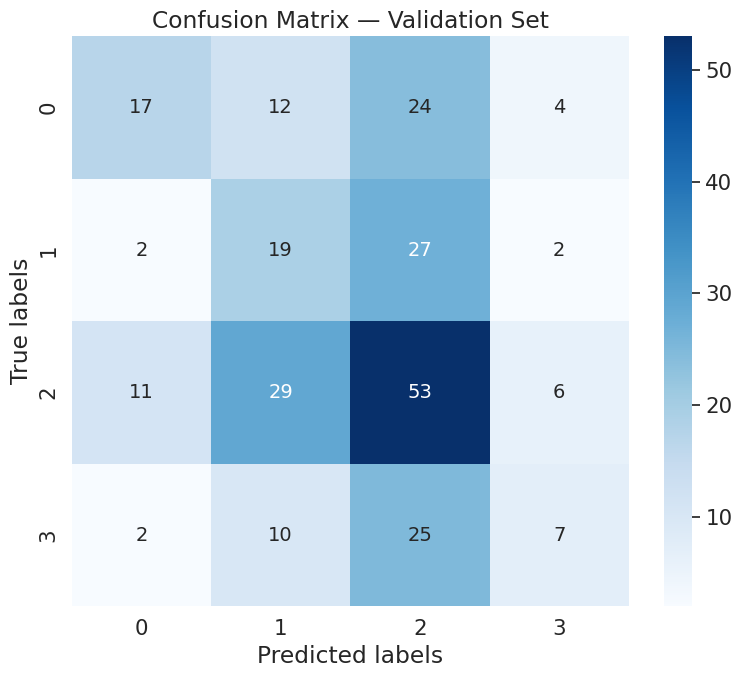

In [52]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = densenet_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [63]:
def visualize_cam(model, images_tensor, original_images, num_to_labels, target_class=None, patch_names=None):
    model.eval()

    # --- 1. hook on the last map's feature of DenseNet121 ---
    # Corrected: DenseNet uses model.features directly, not model.backbone
    target_layer = model.features[-1]
    activations = []

    def hook_fn(m, i, o):
        activations.append(o)

    handle = target_layer.register_forward_hook(hook_fn)

    # --- 2. weight of linear classifier ---
    # Corrected: DenseNet's classifier is directly a linear layer
    fc_weights = model.classifier.weight.data.cpu().numpy()

    # --- 3. predictions ---
    with torch.no_grad():
        outputs = model(images_tensor)
        preds = outputs.argmax(dim=1).cpu().numpy()

    handle.remove()

    acts = activations[0].cpu().numpy()  # shape: [B, C, H, W]
    num_images = len(images_tensor)

    plt.figure(figsize=(18, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        class_idx = target_class if target_class is not None else preds[i]

        # CAM = weighted sum of feature maps
        cam = np.zeros(acts.shape[2:], dtype=np.float32)
        for w, feat in zip(fc_weights[class_idx], acts[i]):
            cam += w * feat

        # normalize + resize
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)
        cam = cv2.resize(cam, (224, 224))

        # overlay
        img = original_images[i]
        plt.imshow(img)
        plt.imshow(cam, cmap="jet", alpha=0.45)

        if patch_names is not None:
            plt.title(f"{patch_names[i]}\n{num_to_labels[class_idx]}", fontsize=10)
        else:
            plt.title(num_to_labels[class_idx], fontsize=12)

        plt.axis("off")

    plt.tight_layout()
    plt.show()


Visualising CAM on validation samples...



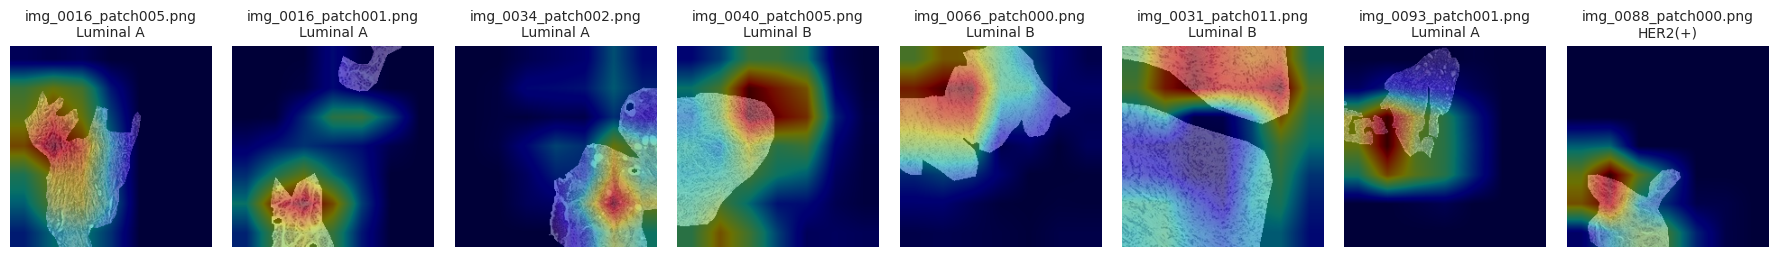

In [64]:
# Pick 5 random validation samples
num_samples = 8
indices = np.random.choice(len(val_ds), num_samples, replace=False)

val_images_raw = []
val_images_tensor = []
val_patch_names = []

# Define num_to_labels using the global label_encoder
num_to_labels = {i: label for i, label in enumerate(label_encoder.classes_)}

for idx in indices:
    img_tensor, label = val_ds[idx]
    val_images_tensor.append(img_tensor)

    # Get the original (pre-transformed) image from X_val directly
    # X_val contains the raw images as NumPy arrays [0,1] in RGB format (H, W, C)
    raw_img = X_val[idx]
    val_images_raw.append(raw_img)

    # Patch name
    val_patch_names.append(patch_files[idx].name)

val_images_tensor = torch.stack(val_images_tensor).to(device)

print("Visualising CAM on validation samples...\n")
visualize_cam(
    densenet_model,
    val_images_tensor,
    val_images_raw,
    num_to_labels,
    patch_names=val_patch_names
)


## EVALUATION ON TEST SET

In [67]:
# Collect predictions and ground truth labels
test_preds, test_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in test_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = best_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        test_preds.append(preds)
        test_targets.append(yb.numpy())

# Combine all batches into single arrays
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

Accuracy over the test set: 0.4762
Precision over the test set: 0.4737
Recall over the test set: 0.4762
F1 score over the test set: 0.4457


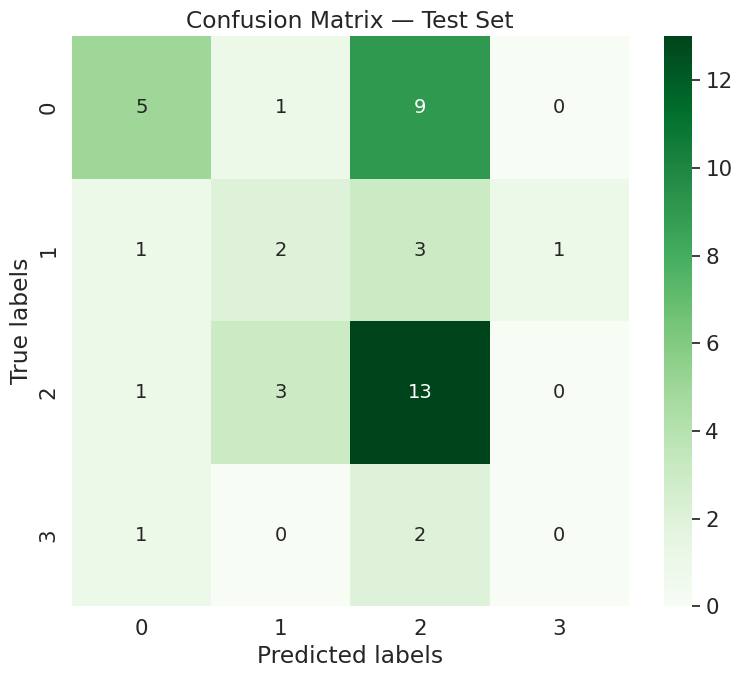

In [68]:
# Calculate overall test accuracy
test_acc = accuracy_score(test_targets, test_preds)
test_prec = precision_score(test_targets, test_preds, average='weighted')
test_rec = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')
print(f"Accuracy over the test set: {test_acc:.4f}")
print(f"Precision over the test set: {test_prec:.4f}")
print(f"Recall over the test set: {test_rec:.4f}")
print(f"F1 score over the test set: {test_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(test_targets, test_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Test Set')
plt.tight_layout()
plt.show()

In [69]:
# Free the RAM before importing test_data and creating its patches

print("Free RAM post-training...")

# Delete dataset and numpy arrays used for training
del X_train, y_train
del X_val, y_val
del X_test, y_test

# # Elimina versioni non codificate se esistono
# for var in ["X_train_list", "X_val_list", "X_test_list",
#             "y_train_list", "y_val_list", "y_test_list"]:
#     if var in globals():
#         del globals()[var]

# Delete PyTorch dataloader
del train_loader
del val_loader
del test_loader

# Delete PyTorch dataset
del train_ds
del val_ds
del test_ds

# # Elimina trasformazioni (non sempre necessario ma meglio)
# del train_transform
# del val_test_transform

# # Elimina oggetti plotting se usati
# try:
#     plt.close('all')
# except:
#     pass

# Delate other heavy variables
to_delete = [
    'patch_files', 'patch_data', 'patches_df',
    'patch_stats', 'removed', 'kept',
    'df_patches'
]
for var in to_delete:
    if var in globals():
        del globals()[var]

# Clean the CUDA cache
torch.cuda.empty_cache()

# Garbage collection
gc.collect()

print("RAM now is free. Now you can proceed with submission file generation")


Free RAM post-training...
RAM now is free. Now you can proceed with submission file generation


In [70]:
import gc
import torch

print("🔥 FULL RAM CLEANUP...")

# 1 — delete every variable related to dataset / patches
patterns = ["X_", "y_", "patch", "train_", "val_", "test_", "df_"]

for var in list(globals().keys()):
    if any(var.startswith(p) for p in patterns):
        if var not in ["model", "label_encoder"]:  # keep only the essentials
            try:
                del globals()[var]
            except:
                pass

# 2 — force garbage collection multiple times
for _ in range(3):
    gc.collect()

# 3 — free GPU
try:
    torch.cuda.empty_cache()
except:
    pass

print("🔥 DONE. Now RAM should drop in ~5 seconds.")


🔥 FULL RAM CLEANUP...
🔥 DONE. Now RAM should drop in ~5 seconds.


## CREATE SUBMISSION FILE

In [71]:
# Create submission file and show some metrics

from datetime import datetime, timedelta

print(f"\n{'='*60}")
print("TEST IMAGE PROCESSING & SUBMISSION")
print(f"{'='*60}")

# Redefine test_data_path as it was cleared by the full RAM cleanup
test_data_path = os.path.join(datasets_path, "test_data")

# Create submissions folder
submissions_folder = "submissions"
os.makedirs(submissions_folder, exist_ok=True)

# Step 1: Create patched test images using GRID-BASED extraction (same as training)
TEST_PATCHED_PATH = Path(datasets_path) / "test_data_patched_new"
TEST_PATCHED_PATH.mkdir(parents=True, exist_ok=True)

test_patch_mapping = []  # Track which patches belong to which image

# Use the trained densenet_model directly
# The variable 'tl_model' will be used for predictions, so it should be the trained model
tl_model = densenet_model
print("Using the trained densenet_model for patch extraction and prediction")

# Get all test image files
test_image_files = sorted([f for f in Path(test_data_path).iterdir() if f.name.startswith('img_')])
print(f"Found {len(test_image_files)} test images")

# Use the same parameters as training
# PATCH_SIZE = 224
OVERLAP = 0.05
MIN_TISSUE_RATIO = 0.05  # Same as training

for img_file in tqdm(test_image_files, desc="Extracting test patches"):
    # Extract image number from filename
    img_number = int(img_file.stem.split('_')[1])

    # Find corresponding mask
    mask_name = f"mask_{img_number:04d}.png"
    mask_path = Path(test_data_path) / mask_name

    if not mask_path.exists():
        tqdm.write(f"Warning: No mask found for {img_file.name}")
        # Track image with no mask
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue

    # Load image and mask
    img = cv2.imread(str(img_file))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        tqdm.write(f"Warning: Could not load {img_file.name} or mask")
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue

    # Threshold mask
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Extract grid patches using the SAME function as training
    patches = extract_grid_patches(
        img,
        binary_mask,
        patch_size=PATCH_SIZE,
        overlap=OVERLAP,
        min_tissue_ratio=MIN_TISSUE_RATIO
    )

    if len(patches) == 0:
        tqdm.write(f"Warning: No valid patches for {img_file.name}")
        # Still track this image (will use default prediction later)
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue

    # Save patches
    for patch_idx, (patch_img, tissue_ratio) in enumerate(patches):
        patch_name = f"img_{img_number:04d}_patch{patch_idx:03d}.png"
        patch_path = TEST_PATCHED_PATH / patch_name
        cv2.imwrite(str(patch_path), patch_img)

        # Track mapping
        test_patch_mapping.append({
            'patch_filename': patch_name,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })

print(f"\nExtracted {len([m for m in test_patch_mapping if m['patch_filename'] is not None])} test patches")
print(f"Images with no patches: {len([m for m in test_patch_mapping if m['patch_filename'] is None])}")

# Step 2: Load test patches and make predictions
print("\nStep 3: Loading test patches for prediction...")

test_patches_list = []
patch_names_list = []

for mapping in tqdm(test_patch_mapping, desc="Loading test patches"):
    if mapping['patch_filename'] is None:
        continue  # Skip images with no patches

    patch_path = TEST_PATCHED_PATH / mapping['patch_filename']

    if not patch_path.exists():
        continue

    # Load patch
    patch_img = cv2.imread(str(patch_path))
    if patch_img is not None:
        # Convert BGR to RGB and normalize
        patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
        test_patches_list.append(patch_rgb)
        patch_names_list.append(mapping['patch_filename'])

# Convert to numpy array
X_test_patches = np.array(test_patches_list)
print(f"Loaded {len(X_test_patches)} test patches")
print(f"Test patches shape: {X_test_patches.shape}")

# Step 3: Generate predictions using the trained model
print("\nStep 4: Generating predictions...")

print("Using trained densenet_model")
model_path = Path("models/cnn_model.pt") # Ensure this path is correct if model was saved under 'cnn_model.pt'

if not model_path.exists():
    # Fallback to the name used in fit function if 'cnn_model.pt' is not found
    model_path = Path(f"models/{experiment_name}_model.pt")
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found at {model_path} or models/cnn_model.pt")

# Load the best model's state dictionary into the densenet_model
densenet_model.load_state_dict(torch.load(model_path, map_location=device))
densenet_model.eval() # Set to evaluation mode
print(f"Loaded model from {model_path.name}")

# Redefine val_test_transform as it was cleared during cleanup
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(Target_dimension),       # Resize in the same way validation and test sets
    transforms.CenterCrop(Target_dimension),
    transforms.ToTensor(),
])

# Define a custom Dataset class for submission images
# It uses the val_test_transform for consistent preprocessing
class SubmissionPredictionDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform:
            # Apply transform, which includes ToPILImage, Resize, CenterCrop, ToTensor
            img = self.transform(img)

        return img, 0 # Dummy label, not used for prediction

# Create dataset and dataloader for test patches
test_patches_ds = SubmissionPredictionDataset(
    X_test_patches,
    transform=val_test_transform # Use the defined val_test_transform
)

test_patches_loader = make_loader(test_patches_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Make predictions
patch_predictions = []
with torch.no_grad():
    for inputs, _ in tqdm(test_patches_loader, desc="Predicting patches"):
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = densenet_model(inputs) # Use densenet_model for prediction
        predictions = logits.argmax(dim=1)
        patch_predictions.extend(predictions.cpu().numpy())

patch_predictions = np.array(patch_predictions)
print(f"Generated {len(patch_predictions)} patch predictions")

# Step 4: Aggregate patch predictions to original images
print("\nStep 5: Aggregating patch predictions to original images...")

# Create a mapping from patch filename to prediction
patch_to_prediction = dict(zip(patch_names_list, patch_predictions))

# Group patches by original image
from collections import defaultdict
image_predictions = defaultdict(list)

for mapping in test_patch_mapping:
    patch_name = mapping['patch_filename']
    original_img_name = mapping['original_img_name']

    if patch_name is not None and patch_name in patch_to_prediction:
        pred = patch_to_prediction[patch_name]
        image_predictions[original_img_name].append(pred)

# Aggregate predictions using majority voting
final_predictions = {}

for img_name, preds in image_predictions.items():
    if len(preds) > 0:
        # Majority vote
        unique, counts = np.unique(preds, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        final_predictions[img_name] = majority_class

# Decode predictions to labels
final_labels = {}
for img_name, pred in final_predictions.items():
    final_labels[img_name] = label_encoder.inverse_transform([pred])[0]

print(f"Generated predictions for {len(final_labels)} test images")
print(f"Images without predictions: {len(test_image_files) - len(final_labels)}")

# Step 5: Create submission file
print("\nStep 6: Creating submission file...")

# Calculate most common class in training data for default
default_label = "Luminal B"

# Get all test image filenames in sorted order
test_filenames = sorted([f.name for f in Path(test_data_path).iterdir() if f.name.startswith('img_')])

# Create submission data
submission_data = []
missing_predictions_count = 0
images_with_default = []

for filename in test_filenames:
    if filename in final_labels:
        label = final_labels[filename]
    else:
        # Use most common training class as default
        print(f"Warning: Image {filename} had no valid patches or predictions, defaulting to {default_label}")
        label = default_label
        missing_predictions_count += 1
        images_with_default.append(filename)

    submission_data.append({
        'sample_index': filename,
        'label': label
    })

# Create DataFrame
submission_df = pd.DataFrame(submission_data)

# Create timestamped filename (YYYY_MM_DD_at_HH_MM)
utc_time = datetime.utcnow()
local_time = utc_time + timedelta(hours=1)
timestamp = local_time.strftime("%Y_%m_%d_at_%H_%M")
submission_path = os.path.join(submissions_folder, f"submission_{timestamp}.csv")

# Save CSV
submission_df.to_csv(submission_path, index=False)

print(f"\n{'='*60}")
print(f"SUBMISSION COMPLETE")
print(f"{'='*60}")
print(f"Submission file saved to: {submission_path}")
print(f"Total predictions: {len(submission_df)}")
print(f"Images with model predictions: {len(final_labels)}")
print(f"Images with default predictions: {missing_predictions_count}")

if missing_predictions_count > 0:
    print(f"\nFirst 20 images with default predictions:")
    for img_name in images_with_default[:20]:
        print(f"  {img_name}")
    if missing_predictions_count > 20:
        print(f"  ... and {missing_predictions_count - 20} more")

print(f"\nLabel distribution in submission:")
label_counts = submission_df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    percentage = (count / len(submission_df)) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")

# Verify submission format
print(f"\n{'='*60}")
print(f"Submission Verification")
print(f"{'='*60}")
print(f"Columns: {list(submission_df.columns)}")
print(f"Number of predictions: {len(submission_df)}")
print(f"Number of unique labels: {submission_df['label'].nunique()}")
print(f"Labels used: {sorted(submission_df['label'].unique())}")
print(f"{'='*60}")


TEST IMAGE PROCESSING & SUBMISSION
Using the trained densenet_model for patch extraction and prediction
Found 477 test images


Extracting test patches:   3%|▎         | 12/477 [00:30<10:20,  1.33s/it]

Extracting test patches:   4%|▍         | 18/477 [00:33<05:15,  1.45it/s]

Extracting test patches:   7%|▋         | 34/477 [00:45<05:43,  1.29it/s]

Extracting test patches:   8%|▊         | 39/477 [00:47<04:16,  1.70it/s]

Extracting test patches:  10%|█         | 50/477 [00:56<06:59,  1.02it/s]

Extracting test patches:  14%|█▍        | 67/477 [01:15<06:50,  1.00s/it]

Extracting test patches:  17%|█▋        | 80/477 [01:26<05:28,  1.21it/s]

Extracting test patches:  18%|█▊        | 86/477 [01:31<05:53,  1.11it/s]

Extracting test patches:  23%|██▎       | 109/477 [01:44<01:29,  4.10it/s]

Extracting test patches:  24%|██▍       | 115/477 [01:51<05:32,  1.09it/s]

Extracting test patches:  25%|██▍       | 117/477 [01:52<04:17,  1.40it/s]

Extracting test patches:  27%|██▋       | 128/477 [01:59<04:16,  1.36it/s]

Extracting test patches:  29%|██▉       | 140/477 [02:07<02:25,  2.32it/s]

Extracting test patches:  31%|███       | 148/477 [02:11<03:06,  1.77it/s]

Extracting test patches:  36%|███▌      | 172/477 [02:31<05:50,  1.15s/it]

Extracting test patches:  37%|███▋      | 177/477 [02:34<04:16,  1.17it/s]

Extracting test patches:  38%|███▊      | 180/477 [02:35<02:41,  1.83it/s]

Extracting test patches:  41%|████      | 195/477 [02:45<03:00,  1.56it/s]

Extracting test patches:  42%|████▏     | 198/477 [02:46<02:04,  2.23it/s]

Extracting test patches:  47%|████▋     | 224/477 [03:12<03:58,  1.06it/s]

Extracting test patches:  56%|█████▌    | 266/477 [03:45<03:36,  1.03s/it]

Extracting test patches:  58%|█████▊    | 278/477 [03:56<02:22,  1.39it/s]

Extracting test patches:  58%|█████▊    | 279/477 [03:57<02:13,  1.48it/s]

Extracting test patches:  61%|██████▏   | 293/477 [04:06<01:40,  1.82it/s]

Extracting test patches:  68%|██████▊   | 324/477 [04:31<03:03,  1.20s/it]

Extracting test patches:  70%|███████   | 335/477 [04:39<02:26,  1.03s/it]

Extracting test patches:  75%|███████▌  | 360/477 [04:56<00:36,  3.17it/s]

Extracting test patches:  77%|███████▋  | 368/477 [05:02<00:58,  1.87it/s]

Extracting test patches:  80%|████████  | 383/477 [05:15<01:24,  1.11it/s]

Extracting test patches:  82%|████████▏ | 392/477 [05:22<01:21,  1.05it/s]

Extracting test patches:  84%|████████▍ | 400/477 [05:30<01:11,  1.07it/s]

Extracting test patches:  84%|████████▍ | 402/477 [05:31<00:55,  1.36it/s]

Extracting test patches:  87%|████████▋ | 413/477 [05:38<00:58,  1.09it/s]

Extracting test patches:  88%|████████▊ | 418/477 [05:39<00:26,  2.26it/s]

Extracting test patches:  88%|████████▊ | 422/477 [05:41<00:23,  2.31it/s]

Extracting test patches:  89%|████████▉ | 426/477 [05:43<00:24,  2.09it/s]

Extracting test patches:  90%|████████▉ | 429/477 [05:44<00:20,  2.38it/s]

Extracting test patches:  91%|█████████ | 432/477 [05:46<00:23,  1.91it/s]

Extracting test patches:  91%|█████████▏| 436/477 [05:48<00:20,  1.99it/s]

Extracting test patches:  95%|█████████▍| 453/477 [05:58<00:07,  3.05it/s]

Extracting test patches: 100%|██████████| 477/477 [06:16<00:00,  1.27it/s]



Extracted 1449 test patches
Images with no patches: 44

Step 3: Loading test patches for prediction...


Loading test patches: 100%|██████████| 1493/1493 [00:10<00:00, 149.20it/s]


Loaded 1449 test patches
Test patches shape: (1449, 224, 224, 3)

Step 4: Generating predictions...
Using trained densenet_model
Loaded model from cnn_model.pt


Predicting patches: 100%|██████████| 46/46 [00:03<00:00, 13.42it/s]


Generated 1449 patch predictions

Step 5: Aggregating patch predictions to original images...
Generated predictions for 433 test images
Images without predictions: 44

Step 6: Creating submission file...

SUBMISSION COMPLETE
Submission file saved to: submissions/submission_2025_12_09_at_23_10.csv
Total predictions: 477
Images with model predictions: 433
Images with default predictions: 44

First 20 images with default predictions:
  img_0012.png
  img_0017.png
  img_0034.png
  img_0039.png
  img_0050.png
  img_0067.png
  img_0080.png
  img_0086.png
  img_0107.png
  img_0108.png
  img_0115.png
  img_0117.png
  img_0128.png
  img_0140.png
  img_0148.png
  img_0172.png
  img_0173.png
  img_0177.png
  img_0180.png
  img_0195.png
  ... and 24 more

Label distribution in submission:
  HER2(+): 60 (12.58%)
  Luminal A: 119 (24.95%)
  Luminal B: 279 (58.49%)
  Triple negative: 19 (3.98%)

Submission Verification
Columns: ['sample_index', 'label']
Number of predictions: 477
Number of unique lab


RANDOM IMAGE + PATCH VISUALIZATION
Selected image: img_0355.png
Total patches: 2
Patch predictions: ['Triple negative' 'Triple negative']
Final majority-vote label: Triple negative



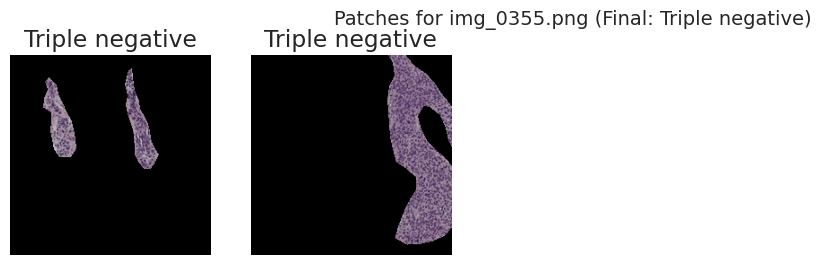

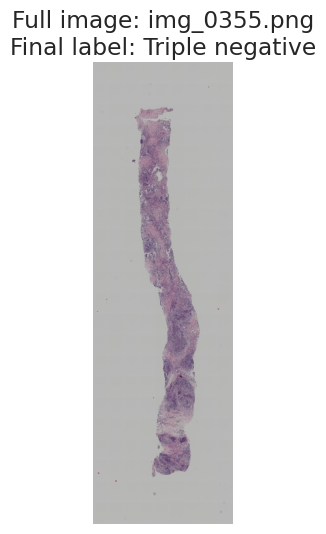

In [72]:
# Show an image with label and all its patches with their specific labels

print("\n" + "="*60)
print("RANDOM IMAGE + PATCH VISUALIZATION")
print("="*60)

# Pick a random test image that has at least one predicted patch
valid_imgs = [img for img in image_predictions.keys() if len(image_predictions[img]) > 0]

if len(valid_imgs) == 0:
    print("No images with patches available for visualization.")
else:
    chosen_img = random.choice(valid_imgs)
    print(f"Selected image: {chosen_img}")

    # Load full image
    full_img_path = Path(test_data_path) / chosen_img
    full_img = cv2.imread(str(full_img_path))
    full_img_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    # Get all associated patches
    related_patches = [
        m["patch_filename"]
        for m in test_patch_mapping
        if m["original_img_name"] == chosen_img and m["patch_filename"] is not None
    ]

    patch_preds = [patch_to_prediction[p] for p in related_patches]
    patch_labels = label_encoder.inverse_transform(patch_preds)

    final_label = final_labels[chosen_img]

    print(f"Total patches: {len(related_patches)}")
    print(f"Patch predictions: {patch_labels}")
    print(f"Final majority-vote label: {final_label}\n")

    # --- Plot patches ---
    cols = 5
    rows = (len(related_patches) + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for i, patch_name in enumerate(related_patches):
        patch_path = TEST_PATCHED_PATH / patch_name
        patch = cv2.imread(str(patch_path))
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(patch_rgb)
        plt.title(f"{patch_labels[i]}")
        plt.axis("off")

    plt.suptitle(f"Patches for {chosen_img} (Final: {final_label})", fontsize=14)
    plt.show()

    # --- Show full image with final label ---
    plt.figure(figsize=(6, 6))
    plt.imshow(full_img_rgb)
    plt.title(f"Full image: {chosen_img}\nFinal label: {final_label}")
    plt.axis("off")
    plt.show()


In [ ]:


# Block code execution
contatore = cont


In [ ]:
# Importing test_data and checking dimensions

TEST_SOURCE_FOLDER = test_data_path
TEST_OUTPUT_FOLDER = os.path.join(datasets_path, "test_masked")

Path(TEST_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

print("Checking test_data content...")
all_test_files = os.listdir(TEST_SOURCE_FOLDER)
imgs = [f for f in all_test_files if f.startswith("img_")]
masks = [f for f in all_test_files if f.startswith("mask_")]

print(f"Found {len(imgs)} images")
print(f"Found {len(masks)} masks")

if len(imgs) != 954 or len(masks) != 954:
    print("WARNING: Expected 954 images and 954 masks!")


Checking test_data content...
Found 954 images
Found 954 masks


In [ ]:
# Apply the masks to the unlabeled images in test_data

print("\nApplying test masks...")
process_batch(TEST_SOURCE_FOLDER, TEST_OUTPUT_FOLDER, target_size=TARGET_SIZE)

print("\nMasking on test set completed!")
print(f"Masked test images saved in: {TEST_OUTPUT_FOLDER}")

# Check output count
masked_files = [f for f in os.listdir(TEST_OUTPUT_FOLDER) if f.startswith("img_")]
print(f"Masked images found: {len(masked_files)}")



Applying test masks...
Scanning for images in: /gdrive/My Drive/AN2DL Challenge 2/test_data...


Processing Images: 100%|██████████| 954/954 [00:00<00:00, 1184.85img/s]


Batch processing complete. Processed 0 new images.

Masking on test set completed!
Masked test images saved in: /gdrive/My Drive/AN2DL Challenge 2/test_masked
Masked images found: 954


In [ ]:
# Define the class SubmissionDataset

class SubmissionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = sorted([
            f for f in os.listdir(root_dir)
            if f.startswith("img_") and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.root_dir, fname)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply same preprocessing used for training/validation
        if self.transform:
            image = self.transform(image)

        # Extract sample_index
        sample_index = int(fname.replace("img_", "").split(".")[0])

        return image, sample_index


In [ ]:
# Test set dataloader

sub_dataset = SubmissionDataset(TEST_OUTPUT_FOLDER, transform=val_test_transform)
sub_loader = DataLoader(sub_dataset, batch_size=32, shuffle=False)

print("\nTest Dataset Summary:")
print(f"Total samples: {len(sub_dataset)} (expected 954)")



Test Dataset Summary:
Total samples: 954 (expected 954)


In [ ]:
# Do predictions on the unlabeled test set images

# Create a new transform for submission data.
# SubmissionDataset already provides PIL images, so transforms.ToPILImage() is not needed
# and causes a TypeError with torchvision.transforms.v2 when applied redundantly.
sub_transform = transforms.Compose([
    transforms.Resize(Target_dimension),
    transforms.CenterCrop(Target_dimension),
    transforms.ToTensor(),
])

# Re-initialize the submission dataset and loader with the corrected transform
sub_dataset = SubmissionDataset(TEST_OUTPUT_FOLDER, transform=sub_transform)
sub_loader = DataLoader(sub_dataset, batch_size=32, shuffle=False)

densenet_model.eval()

sub_preds = []
sub_indices = []

print("\nRunning inference on test set...")

with torch.no_grad():
    for images, sample_indices in tqdm(sub_loader, desc="Batches processed"):
        images = images.to(device)

        outputs = densenet_model(images)
        _, preds = torch.max(outputs, 1)

        sub_preds.extend(preds.cpu().numpy())
        sub_indices.extend(sample_indices)

print("\nInference finished!")
print(f"Predictions obtained: {len(sub_preds)}")
print(f"Sample indices collected: {len(sub_indices)}")

pred_labels = label_encoder.inverse_transform(sub_preds)   # convert indices back to strings

print("\nExample label mapping:")
for i in range(5):
    idx = int(sub_indices[i])         # convert tensor as int
    fname = f"img_{idx:04d}.png"      # define the correct filename format
    print(f"{fname}   ->   {pred_labels[i]}")



Running inference on test set...


Batches processed: 100%|██████████| 30/30 [00:37<00:00,  1.23s/it]


Inference finished!
Predictions obtained: 954
Sample indices collected: 954

Example label mapping:
img_0000.png   ->   HER2(+)
img_0001.png   ->   HER2(+)
img_0002.png   ->   HER2(+)
img_0003.png   ->   HER2(+)
img_0004.png   ->   HER2(+)


In [ ]:
# Create final submission file

from datetime import datetime, timedelta

# Create submissions folder
submissions_folder = "submissions"
os.makedirs(submissions_folder, exist_ok=True)

# Convert prediction indices -> original string labels
pred_labels = label_encoder.inverse_transform(sub_preds)

# Convert sample_indices back to filenames (img_XXXX.png)
file_names = [f"img_{idx:04d}.png" for idx in sub_indices]

# Build dataframe
df_sub = pd.DataFrame({
    "sample_index": file_names,
    "label": pred_labels
})

# Sort by filename order
df_sub.sort_values("sample_index", inplace=True)

# Create timestamped filename (YYYY_MM_DD_at_HH_MM)
utc_time = datetime.utcnow()
local_time = utc_time + timedelta(hours=1)
timestamp = local_time.strftime("%Y_%m_%d_at_%H_%M")
submission_path = os.path.join(submissions_folder, f"submission_{timestamp}.csv")

# Save CSV
df_sub.to_csv(submission_path, index=False)

print("\nSubmission file successfully generated!")
print(f"Saved at: {submission_path}")
print(df_sub.head())
print(df_sub.tail())
print(f"\nTotal rows: {len(df_sub)} (should be 954)")
